In [1]:
# Installing all the necessary packages(libraries) for the experiments (RTX30xx, RTX40xx, A100, H100, L40)
!pip install --no-deps packaging ninja einops flash-attn xformers trl peft accelerate bitsandbytes
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.7 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.5.9.post1-cp310-cp310-linux_x86_64.whl size=120889689 sha256=5022ba11d48bf74926da9c16260f4ea2b9bb7f4e29bdb4bd6e1383ad1c55d16f
  Stored in directory: /root/.cache/pip/wheels/cc/ad/f6/7ccf0238790d6346e9fe622923a76ec218e890d356b9a2754a
Successfully built

In [2]:
# Installing all the necessary packages(libraries) for the experiments (V100, T4, RTX20xx)
!pip install --no-deps xformers trl peft accelerate bitsandbytes
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-ldby1wxp/unsloth_9933a9afd1df437c8e6207ade2331b53
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-ldby1wxp/unsloth_9933a9afd1df437c8e6207ade2331b53
  Resolved https://github.com/unslothai/unsloth.git to commit 27fa021a7bb959a53667dd4e7cdb9598c207aa0d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
# Importing the necessary packages(libraries) for the experiments
import json

import torch
from datasets import load_dataset
from huggingface_hub import notebook_login
from transformers import TrainingArguments
from trl import SFTTrainer
from unsloth import FastLanguageModel

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [4]:
# Logging into the Hugging Face Hub(with token)
notebook_login()

In [5]:
# Defining the configuration for the base model, LoRA and training
config = {
    "hugging_face_username":"Shekswess",
    "model_config": {
        "base_model":"unsloth/llama-3-8b-Instruct-bnb-4bit", # The base model
        "finetuned_model":"llama-3-8b-Instruct-bnb-4bit-medical", # The finetuned model
        "max_seq_length": 2048, # The maximum sequence length
        "dtype":torch.float16, # The data type
        "load_in_4bit": True, # Load the model in 4-bit
    },
    "lora_config": {
      "r": 16, # The number of LoRA layers 8, 16, 32, 64
      "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"], # The target modules
      "lora_alpha":16, # The alpha value for LoRA
      "lora_dropout":0, # The dropout value for LoRA
      "bias":"none", # The bias for LoRA
      "use_gradient_checkpointing":True, # Use gradient checkpointing
      "use_rslora":False, # Use RSLora
      "use_dora":False, # Use DoRa
      "loftq_config":None # The LoFTQ configuration
    },
    "training_dataset":{
        "name":"Shekswess/medical_llama3_instruct_dataset_short", # The dataset name(huggingface/datasets)
        "split":"train", # The dataset split
        "input_field":"prompt", # The input field
    },
    "training_config": {
        "per_device_train_batch_size": 2, # The batch size
        "gradient_accumulation_steps": 4, # The gradient accumulation steps
        "warmup_steps": 5, # The warmup steps
        "max_steps":0, # The maximum steps (0 if the epochs are defined)
        "num_train_epochs": 1, # The number of training epochs(0 if the maximum steps are defined)
        "learning_rate": 2e-4, # The learning rate
        "fp16": not torch.cuda.is_bf16_supported(), # The fp16
        "bf16": torch.cuda.is_bf16_supported(), # The bf16
        "logging_steps": 1, # The logging steps
        "optim" :"adamw_8bit", # The optimizer
        "weight_decay" : 0.01,  # The weight decay
        "lr_scheduler_type": "linear", # The learning rate scheduler
        "seed" : 42, # The seed
        "output_dir" : "outputs", # The output directory
    }
}

In [6]:
# Loading the model and the tokinizer for the model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = config.get("model_config").get("base_model"),
    max_seq_length = config.get("model_config").get("max_seq_length"),
    dtype = config.get("model_config").get("dtype"),
    load_in_4bit = config.get("model_config").get("load_in_4bit"),
)

# Setup for QLoRA/LoRA peft of the base model
model = FastLanguageModel.get_peft_model(
    model,
    r = config.get("lora_config").get("r"),
    target_modules = config.get("lora_config").get("target_modules"),
    lora_alpha = config.get("lora_config").get("lora_alpha"),
    lora_dropout = config.get("lora_config").get("lora_dropout"),
    bias = config.get("lora_config").get("bias"),
    use_gradient_checkpointing = config.get("lora_config").get("use_gradient_checkpointing"),
    random_state = 42,
    use_rslora = config.get("lora_config").get("use_rslora"),
    use_dora = config.get("lora_config").get("use_dora"),
    loftq_config = config.get("lora_config").get("loftq_config"),
)

# Loading the training dataset
dataset_train = load_dataset(config.get("training_dataset").get("name"), split = config.get("training_dataset").get("split"))

# Setting up the trainer for the model
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset_train,
    dataset_text_field = config.get("training_dataset").get("input_field"),
    max_seq_length = config.get("model_config").get("max_seq_length"),
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = config.get("training_config").get("per_device_train_batch_size"),
        gradient_accumulation_steps = config.get("training_config").get("gradient_accumulation_steps"),
        warmup_steps = config.get("training_config").get("warmup_steps"),
        max_steps = config.get("training_config").get("max_steps"),
        num_train_epochs= config.get("training_config").get("num_train_epochs"),
        learning_rate = config.get("training_config").get("learning_rate"),
        fp16 = config.get("training_config").get("fp16"),
        bf16 = config.get("training_config").get("bf16"),
        logging_steps = config.get("training_config").get("logging_steps"),
        optim = config.get("training_config").get("optim"),
        weight_decay = config.get("training_config").get("weight_decay"),
        lr_scheduler_type = config.get("training_config").get("lr_scheduler_type"),
        seed = 42,
        output_dir = config.get("training_config").get("output_dir"),
    ),
)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
# Memory statistics before training
gpu_statistics = torch.cuda.get_device_properties(0)
reserved_memory = round(torch.cuda.max_memory_reserved() / 1024**3, 2)
max_memory = round(gpu_statistics.total_memory / 1024**3, 2)
print(f"Reserved Memory: {reserved_memory}GB")
print(f"Max Memory: {max_memory}GB")

Reserved Memory: 5.59GB
Max Memory: 14.75GB


In [8]:
# Training the model
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 250
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,3.088900
2,3.489900
3,3.294400
4,2.442800
5,2.188100
6,1.803000
7,1.810400
8,1.763500
9,1.316100
10,1.706000


In [9]:
# Memory statistics after training
used_memory = round(torch.cuda.max_memory_allocated() / 1024**3, 2)
used_memory_lora = round(used_memory - reserved_memory, 2)
used_memory_persentage = round((used_memory / max_memory) * 100, 2)
used_memory_lora_persentage = round((used_memory_lora / max_memory) * 100, 2)
print(f"Used Memory: {used_memory}GB ({used_memory_persentage}%)")
print(f"Used Memory for training(fine-tuning) LoRA: {used_memory_lora}GB ({used_memory_lora_persentage}%)")

Used Memory: 9.81GB (66.51%)
Used Memory for training(fine-tuning) LoRA: 4.22GB (28.61%)


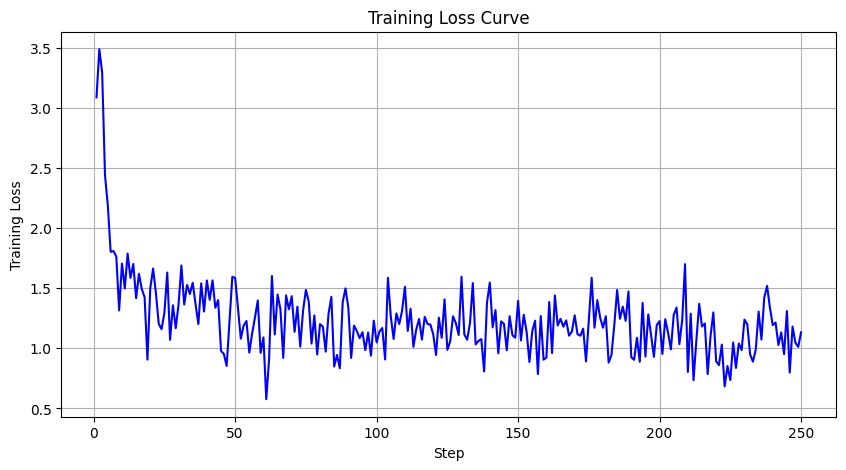

In [18]:
import matplotlib.pyplot as plt

trainer.state.log_history
train_loss = []
for elem in trainer.state.log_history:
    if 'loss' in elem.keys():
        train_loss.append(elem['loss'])

steps = range(1, len(train_loss) + 1)

# Plot the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, linestyle='-', color='b')
plt.xlabel('Step')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

In [10]:
# Saving the trainer stats
with open("trainer_stats.json", "w") as f:
    json.dump(trainer_stats, f, indent=4)

In [ ]:
# Locally saving the model and pushing it to the Hugging Face Hub (only LoRA adapters)
model.save_pretrained(config.get("model_config").get("finetuned_model"))
model.push_to_hub(config.get("model_config").get("finetuned_model"), tokenizer = tokenizer)

README.md:   0%|          | 0.00/599 [00:00<?, ?B/s]

Saved model to https://huggingface.co/llama-3-8b-Instruct-bnb-4bit-medical


In [ ]:
# Saving the model using merged_16bit(float16), merged_4bit(int4) or quantization options(q8_0, q4_k_m, q5_k_m)...
model.save_pretrained_merged(config.get("model_config").get("finetuned_model"), tokenizer, save_method = "merged_16bit",)
model.push_to_hub_merged(config.get("model_config").get("finetuned_model"), tokenizer, save_method = "merged_16bit")

model.save_pretrained_merged(config.get("model_config").get("finetuned_model"), tokenizer, save_method = "merged_4bit",)
model.push_to_hub_merged(config.get("model_config").get("finetuned_model"), tokenizer, save_method = "merged_4bit")

model.save_pretrained_gguf(config.get("model_config").get("finetuned_model"), tokenizer)
model.push_to_hub_gguf(config.get("model_config").get("finetuned_model"), tokenizer)

model.save_pretrained_gguf(config.get("model_config").get("finetuned_model"), tokenizer, quantization_method = "f16")
model.push_to_hub_gguf(config.get("model_config").get("finetuned_model"), tokenizer, quantization_method = "f16")

model.save_pretrained_gguf(config.get("model_config").get("finetuned_model"), tokenizer, quantization_method = "q4_k_m")
model.push_to_hub_gguf(config.get("model_config").get("finetuned_model"), tokenizer, quantization_method = "q4_k_m")

Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which will take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 5.7G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 6.5 out of 12.67 RAM for saving.


100%|██████████| 32/32 [00:54<00:00,  1.71s/it]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Unsloth: Saving llama-3-8b-Instruct-bnb-4bit-medical/pytorch_model-00001-of-00004.bin...
Unsloth: Saving llama-3-8b-Instruct-bnb-4bit-medical/pytorch_model-00002-of-00004.bin...
Unsloth: Saving llama-3-8b-Instruct-bnb-4bit-medical/pytorch_model-00003-of-00004.bin...
Unsloth: Saving llama-3-8b-Instruct-bnb-4bit-medical/pytorch_model-00004-of-00004.bin...
Done.
Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 6.43 out of 12.67 RAM for saving.


100%|██████████| 32/32 [02:07<00:00,  3.97s/it]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Unsloth: Saving llama-3-8b-Instruct-bnb-4bit-medical/pytorch_model-00001-of-00004.bin...
Unsloth: Saving llama-3-8b-Instruct-bnb-4bit-medical/pytorch_model-00002-of-00004.bin...
Unsloth: Saving llama-3-8b-Instruct-bnb-4bit-medical/pytorch_model-00003-of-00004.bin...
Unsloth: Saving llama-3-8b-Instruct-bnb-4bit-medical/pytorch_model-00004-of-00004.bin...
Done.
Saved merged model to https://huggingface.co/None/llama-3-8b-Instruct-bnb-4bit-medical


RuntimeError: Unsloth: Merging into 4bit will cause your model to lose accuracy if you plan
to merge to GGUF or others later on. I suggest you to do this as a final step
if you're planning to do multiple saves.
If you are certain, change `save_method` to `merged_4bit_forced`.

In [ ]:
# Loading the fine-tuned model and the tokenizer for inference
model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = config.get("model_config").get("finetuned_model"),
        max_seq_length = config.get("model_config").get("max_seq_length"),
        dtype = config.get("model_config").get("dtype"),
        load_in_4bit = config.get("model_config").get("load_in_4bit"),
    )

# Using FastLanguageModel for fast inference
FastLanguageModel.for_inference(model)

# Tokenizing the input and generating the output
inputs = tokenizer(
[
    "<|start_header_id|>system<|end_header_id|> Answer the question truthfully, you are a medical professional.<|eot_id|><|start_header_id|>user<|end_header_id|> This is the question: Can you provide an overview of the lung's squamous cell carcinoma?<|eot_id|>"
], return_tensors = "pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens = 256, use_cache = True)
tokenizer.batch_decode(outputs, skip_special_tokens = True)

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


["system Answer the question truthfully, you are a medical professional.user This is the question: Can you provide an overview of the lung's squamous cell carcinoma?assistant Squamous cell carcinoma of the lung is a type of non-small cell lung cancer."]

In [ ]:
inputs = tokenizer(
[
    "<|start_header_id|>system<|end_header_id|> Answer the question truthfully, you are a medical professional.<|eot_id|><|start_header_id|>user<|end_header_id|> This is the question: Can you provide an overview of the lung's squamous cell carcinoma?<|eot_id|>"
], return_tensors = "pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens = 500, use_cache = True)
tokenizer.batch_decode(outputs, skip_special_tokens = True)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


["system Answer the question truthfully, you are a medical professional.user This is the question: Can you provide an overview of the lung's squamous cell carcinoma?assistant Squamous cell carcinoma of the lung is a type of non-small cell lung cancer."]

In [ ]:
!pip install bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 905.2 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: how do i stop smoking now
Expected Answer: stopping smoking is about will power and being steadfast. you can stop safely by having bupropion or nicotine patch cover initially in consult with a doctor. contact an addiction clinic near you. wishing you best of health thanks
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: how do i stop smoking now assistant Smoking cessation is the most effective way to prevent lung cancer.
BERTScore - Precision: 0.4795856475830078, Recall: 0.4700198173522949, F1: 0.47475454211235046



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i had a tubaligation 4 years ago and also have a minor case of endometriosis i am only 27 and my period stopped completely 3 months ago no more spotting in between nothing i am not stressed no change in daily habits diet weight nothing all urine pregnancy tests have been negative what could be wrong with me?
Expected Answer: hello this sounds quite unfamiliar that due to no reason at this age you have no cycle for last three months. pregnancy is surely a remote possibility as there was a tubal ligation. the endometriosis is also unlikely could cause stoppage of cycle. you definitely need some hormonal tests like thyroid or prolactin to know the balance inside as well as an withdrawal bleeding. meet your doctor for an evaluation.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i had a tubaligation 4 years ago and also have a minor case of endometriosis i am only 27 and my period stopped completely 3 months ago 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: could extra caffeine consumption be a cause of mild unilateral breast tenderness?
Expected Answer: extra caffeine can cause gastric discomfort the pain of which can be felt at one side of breast mostly left side but right also is possible and some times whole chest. get evaluated for any local pathology like mastitis. i hope it helps. stay in touch with your healthcare provider for further guidance as our answers are just for education and counselling purposes and cannot be an alternative to actual visit to a doctor. take care khan
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: could extra caffeine consumption be a cause of mild unilateral breast tenderness? assistant There are no established guidelines for the management of breast tenderness.
BERTScore - Precision: 0.5294378399848938, Recall: 0.47853389382362366, F1: 0.5027005076408386



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hello- i am a 24 year old female 5"4 & 115 lb & was diagnosed with pcos at 19. i've always been active & extremely healthy. spironolactone & an iud helped with acne & pain but in 2013 i had an ovarian torsion requiring surgery & they saved my right ovary. i began having hair loss from telogen effogen & reoccurant yeast infections- i was diagnosed as pre-diabetic & cut sugar our from my already low sugar diet. fast forward to january of this year i went to the er due to pain from another torsion on the right side & again the ovary was saved. i was put on ortho tricyclen lo & still have my iud & take the spironolactone but had horribly painful cysts last month which brought me to the er but with no torsion they did nothing. the pain has been intermitten since & is getting more severe. it feels like ice cubes in my ovaries & warm water/electic shocks down my thighs. i had the hpv vaccine but my last pap showed up irregular & the biopsy of cysts got lost. any thoughts on what hap

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i was wanting to know if you could tell me if its possible for a woman to go through all their pregnancy without knowing they are pregnant and have periods and ngative pregnancy tests? iwas watching the show called "i didnt know i was pregnant" and wanted to know how real and accurate this show is and how somthing like that could happen?
Expected Answer: i am glad to help you out. this is not possible scientifically for a woman not to know and still be pregnant throughout the pregnancy. it is also not possible for the periods to continue and still be pregnant. the confirmation can be done by doing a urine pregnancy test or an ultrasound abdomen. the story of âi didnât know i was pregnantâ seems more like a fiction and less like a reality. i sincerely hope that helps. take care.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i was wanting to know if you could tell me if its possible for a woman to go thr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i have been taking methadose and oxycotin illeagely for over a year now. i am now trying to quit. the withdrawls are the worst thing i have ever experienced. so i keep going back to get more. i have no insurance and i dont have the money to go to the e. r. is there any way i can ease the pain so i can get my life back in order. please help i dont know what to do.
Expected Answer: you are not alone. you should consider expert help from medical professionals who specialize in drug treatment. there are specialists who can counsel you during your detoxification from narcotics and provide medical assistance during this process. also you can call a drug or alcohol helpline to identify treatment centers in your area. treatment centers medically intake patients for as long as is necessary for you to understand the disease of drug addiction learn preventative measures to counter the disease and develop belief that there is life after methadone and oxycotin. further you may need the su

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i need help i drink every night and think that it has something to do with my personal life and the way i deal with things. i used to love my job and the banter now they are making me feel down and worthless. my husband has been doing this for a while now and i really need some help to stop other people making me feel so useless and worthless.
Expected Answer: it is difficult to analyse your situation without a physical examination and a psychiatric complete history. you might definitely benefit by consulting a psychiatrist who can help you properly in dealing with your problems and prescribe you medications if needed.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i need help i drink every night and think that it has something to do with my personal life and the way i deal with things. i used to love my job and the banter now they are making me feel down and worthless. my husband has been doing this for a wh

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i have had a lot of trouble getting off of narcotics (percocet and morphine my knee surgeon would give me the percocet and my family dr would give me the morphine) but this time i have actually done it. my last time using it was on new years eve. physically i am fine. mentally though i keep getting cravings for it and i try to figure out how to get more. (surgeon said if i need some go to my family doctor. family doctor would not give me anymore due to asking for refills too soon after getting a rx. ) i then tell myself "no" and then remind myself how far i have come. my question is: how long will it take for the mental withdrawl to go away? i am getting scared that i may given into one of those cravings and go to a hospital to get some. any suggestions on how to deal with this would be greatly appreciated.
Expected Answer: given the description you could be experiencing mental dependency on narcotics. it doesnât seem that you are physically dependent on narcotics currently

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi. my name is roberto writing from italy. i write here because i'd have a question i can't resolve in my hometown. let me introduce me: i'm a karate black belt and i like to study anatomy in order to be as more effective as i can. my question is about windpipe's rings resistance to pressure and/or strikes. in short i'd like to know how much it takes to crush/to flat trachea's cartilages with a sharp strike to the cervical part of the throat. thankyou for your attention and patience.
Expected Answer: it does not take much force at all to crush the larynx. crushing the human throat takes roughly that same amount of pressure as crushing an empty soda container. this is why a move such as a throat gouge should never be used in a fight. the only time this kind of move should be used is if it is life or death. a hit to the throat can easily kill a person and is not to joked with. i hope this clears your doubts.
Generated Answer: system Answer the question truthfully, you are a med

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: the stool color is black (not loose) - is the black color of stool due to any of the above medicines? being holiday can not consult doctor instantly
Expected Answer: medicines that contain iron like tonoferon usually causes black stool.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: the stool color is black (not loose) - is the black color of stool due to any of the above medicines? being holiday can not consult doctor instantly assistant There are no specific treatments for black stools.
BERTScore - Precision: 0.38447532057762146, Recall: 0.4856562316417694, F1: 0.4291829764842987



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: why is it that the medical profession is so behind the times when it comes to considering the feelings of husbands as it pertains to their wive's medical care. i just recently learned about the exams my wife has been subjected to on a yearly basis (at least one of the following: pelvic exam pap smear breast exam). it depresses and angers me that a male physician can perform those exams without my consent. meanwhile the same doctor over the course of more than 10 years has never asked me to remove anything more than my shirt while she is asked to strip down every time she sees him. i think without the consent of both partners in a marriage that it should be illegal for an opposite sex health care professional to perform invasive exams of this nature. we're not talking about an emergency here and i feel that he has caused irreparable damage to our marriage and has taken something from me that i can't ever get back. what is your take on this?
Expected Answer: you are right but t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: is it best to start on sinemet or "hold off".
Expected Answer: sinemet is a combination of levodopa and carbidopa. this medicine is used for treating parkinsonâs disease. the choice of medicine(s) and dosage is strongly individual. you can consult your neurologist on whether or not to start sinemet or wait and hold off.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: is it best to start on sinemet or "hold off". assistant There is no evidence to support the use of Sinemet in the treatment of Parkinson's disease.
BERTScore - Precision: 0.5629273056983948, Recall: 0.5514472723007202, F1: 0.5571281313896179



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i may need diagnostic testing and this time i have a trail period before i can get my health insurance. i would be a self-pay pt and fear the cost of such tests. if i go to an emergency room can i convince them to order mris cts without insurance if i am concerned? i am putting this off for as long as i can right now.
Expected Answer: you need to confirm with your insurance provider regarding coverage of investigation and consultation charges during your trial period. if these investigations are covered by your insurance provider during the trial period then these would be done for you during your visit to emergency. if these investigations are required to be done immediately then the doctors in the emergency room will get these done (as based on your examination findings and current health status) and you need to pay for them yourself in case your insurance provider does not cover these. you need not have to convince them to get these done. take care.
Generated Answer: syste

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: its been since august 15 2012 and i have had issues. the incision in my bellybutton keeps spliting open infection. my dr. told me no it is not infection! did nothing! everything i try to eat even (one) bite. it feels like a rubber band is snapping inside! when i sleep on my left side everything on the right settles i feel something moving! there is an egg sized (? ) in the center between my navel and ribs. what could possibly cause the snapping feeling and what could possibly be moving inside me? kind of freaked out especially when my dr. who is a ta says nothing is wrong. i was 110 when this all began i am under 100 lbs i am 5ft 5in and nothing tastes good smells good and i'm nausious all the time.
Expected Answer: it seems you are suffering from reflux and gastritis which is a common issue after gall bladder removal. regarding the abnormal feeling it requires a clinical examination to comment regarding the exact cause. it might be that the incision site is healing which can

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hello i've had an endoscopic sinus surgery some days ago. my doctor didn't gave me any specific guidance and i've had sex with my wife from the 2nd day after surgery. i saw some websites which prohibited patients from strenuous activities as sex so i was wondering if it is so harmful? and if yes why? or it will just cause bleeding from sinuses? i have some kind of headaches now and i'm really worried so any help is so appreciated! thanks in advance for your attention!
Expected Answer: yes after the surgery any strenous activty including intercourse is to be avoided for a week to avoid any pressure in the sinuses as it can lead to bleeding. relax yourself as headache which is moderate in intensity could be present in some patients for several weeks following surgery. if you notice any other symptom as severe pain bleeding fever decrease in vision double vision then consider visiting your treating doctor immediately. avoid blowing your nose also for a week. take care!
Generated

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: abortion benefits
Expected Answer: abortion the clinical way of stopping an unplanned/unprepared/unhealthy pregnancy.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: abortion benefits assistant There are no benefits to abortion.
BERTScore - Precision: 0.4019319415092468, Recall: 0.39064449071884155, F1: 0.3962078392505646



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i had a surgical-abortion a year ago now am pregnant again but this time iam thinking of having a medical-abortion is my medical-abortion going to have any trouble because i had a surgical abortion a year ago?
Expected Answer: the term medical abortion is used when a medicine is given in order to perform a chemically induced abortion. the results are better if the medication is given earlier. there are various medications that might be used. most of the women would abort within hours but it can also take up to several weeks to complete the abortion. the complications are usually rare. anyway a prolonged bleeding might occur that will need a suction. most doctors and researcher agree that a prior surgical abortion is not a contraindication for a medical abortion. however the medical abortion has to be advised and led by a doctor after a complete examination of the woman.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the qu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: how i loose my waight
Expected Answer: obesity needs to be documented first by calculating the bmi i. e the body mass index if obesity is present a lipid profile should also be done along with crp/esr to prevent atherosclerosis progression. thyroid profile should also be done as part of the workup. limiting caloric intake division into small meals increasing dry fiber intake and regular exercise can be applied as part of daily routine to have a controlled reduction in weight. please consult a nutritionist regarding your daily diet so that he/she may alter it according to your preference as much as possible. wishing you best of health thanks
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: how i loose my waight assistant There are many ways to lose weight. Here are some tips that may help: 1. Eat a healthy diet. A diet that is high in fruits, vegetables, whole grains, and lean protein can help you lose weight. 2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i am very concerned about my girlfriend's weight. she is 21 years old 5'5" and 249lbs. she has gained almost 60lbs in the last two years. i also know for a fact that she was less than 140lbs when she was sixteen and this gaining seems to be way out of control. i am very worried because she seems so tired she is out of shape avoid stairs - if we have to use the stairs she is always out of breath. as i write i am very worried but i don't know what to do or how this weight will affect her. i've never been overweight myself but always heard about how difficult and harmful it is. given her recent weight gain what is the risk factors for her? if she goes to her doctor will the doctor mention her weight? because most 21 year old girls wouldn't get out of breath by just walking some stairs right.
Expected Answer: yes you are right. the four main causes which need to be ruled out in her case are anemia low thyroid function diabetes and polycystic ovary. if these are ruled out then oth

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: is there a way to get monolids? (naturally)
Expected Answer: monolid or mono eyelid or epicanthic fold (technical term) is a single eyelid instead of double eyelids. this pattern of eyelids is usually a genetic inheritence (by birth) and there is no other way to acquire it naturally. epicanthic fold or monolid is believed to have evolved in order to provide defense from the extreme cold and extreme light that occur in eurasian arctic and northern regions. they also protect eyes against dust in areas of deserts such as of northern china and mongolia and some parts of africa. monolid is seen naturally in - - mongoloid asians - europeans (scandinavians poles germans the irish and british. ) and - africans you can consult a cosmetic surgeon and seek a opinion if you are interested in it. i hope this helps.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: is there a way to get monolids? (naturally) assistant Monolid

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi there! i am a 20 year old girl with extremely large breasts. since i was 12 years old and hit puberty my breasts have always been above average. at that age i wore a 36c and have continued to go up since then. i now wear a 34ff after being properly fitted. my question relates to whether or not i will be covered. i suffer from back pain and shoulder pain including debilitating spasms and have since developed mild scoliosis. i am in almost constant pain from my back or shoulders and in order to exercise i need to wear at least 3 bras usually 2 sports bras and 1 regular one. in everyday life i have to wear two bras and because of this i have deep lines on my sides shoulders and back from the straps and have to put cream on the raw skin. i also want to know what the chances are i will be able to breast feed and whether or not i can have this surgery now or do i need to wait until i'm older? thanks so much
Expected Answer: whether your surgery will be covered depends on whether

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i'm factor v laiden and was wondering if it's safe for me to start taking borage oil? i've been researching online and have not been able to get any information on this topic.
Expected Answer: hi thank you for contacting ehf. borage oil in preliminary research has been shown to potentiate the effect of warfarin which you must be on since you are factor v leiden patient. thus please avoid the use of it to prevent the interaction. also don't forget to do your scheduled inr dr. khan.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i'm factor v laiden and was wondering if it's safe for me to start taking borage oil? i've been researching online and have not been able to get any information on this topic. assistant Borage oil is generally considered safe for use in the recommended dietary amounts. However, it may cause some side effects, such as stomach upset, diarrhea, and allergic reactions.
BERTScore - Precision

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: how can i control the lipomo. i have many nos. oflipomo in my body. pls advse
Expected Answer: hello and welcome to ehealth forum! what you describe as âmultiple lipomoâ is probably âlipomasâ. the exact cause of lipomas isn't known. lipomas tend to run in families as hereditary familial lipomatosis so genetic factors play a role in some cases. sometimes lipomas occur after an injury but it cannot be said for sure whether they are caused by the trauma or whether they were accidently detected after injury. coming back to your question it is difficult to say how to control it as the cause is not known. since you have many of them there is a chance that it runs in your family. this is a benign tumor (not cancerous) and hence generally left as it is. hope this helps. take care!
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: how can i control the lipomo. i have many nos. oflipomo in my body. pls advse assis

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: how well homeopathic medicine such as rescue remedy or aconitum works for anxiety? any side effects? my therapist recommended to me but i'm still not sure.
Expected Answer: sorry i am an allopathic doctor and do not have any idea about homeopathic medications. but usually homeopathic medicines do not cause any severe side effects if taken accordingly as recommended and one medicine might work on different indications with different doses and recommendations. take care!
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: how well homeopathic medicine such as rescue remedy or aconitum works for anxiety? any side effects? my therapist recommended to me but i'm still not sure. assistant Rescue Remedy is a homeopathic remedy that is used to treat anxiety and stress. It is a combination of five homeopathic remedies: Aconitum, Arnica, Gelsemium, Impatiens, and Belladonna. It is available in various forms such as tablets,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i am a collegiate baseball pitcher and i would like to increase my velocity. what are some safe vitamins or supplements i could take to increase muscle mass and endurance?
Expected Answer: regular over the counter vitamins and balanced diet and lifestyle is all you need. avoid cheap publicity stunts claiming to increase endurance etc as none of these are legal and healthy. stick to natural ways and exercise and keep doing it as they say try try again. i hope it helps. stay in touch with your healthcare provider for further guidance as our answers are just for education and counselling purposes and cannot be an alternative to actual visit to a doctor. take care khan
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i am a collegiate baseball pitcher and i would like to increase my velocity. what are some safe vitamins or supplements i could take to increase muscle mass and endurance? assistant There are no supple

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i was diagnosed of pcos and last 2 week went for a my doctor's visit and she said my sugar level is a bit higher than normal but i forgot asking how many it was. then she asked me to follow diet and also placed me on metformin 500mg. i am so worried considering the fact that i am polycistic. please can some one advise me on what find of food is best for me now and what to avoid? does this means that i will end up in diabetes? pls help! thansk
Expected Answer: in polycystic ovaries the hormone dis-balance is such that there are long intervals in between two periods. relax deranged sugar levels are common in pcod but that does not mean that you would have diabetes in future. metformin is commonly prescribed in case of pcod. doing some lifestyle changes will help you like- 1. reduce saturated fat intake. 2. maintain good body composition. 3. increase dietary fiber. 4. increase aerobic exercise. 5. restrict sugar intake. you can also consider visiting a dietician who can help you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: if you say rice is no good because it can cause high blood sugar then what can we consume for carbohydrates that's safe? is brown rice ok? how about sweet potato? what is safe?
Expected Answer: high blood sugar can cause various complications if not controlled. for patiens suffering from increased blood sugar a low carbohydrate and high fibre diet is the best diet which helps in providing energy and also maintains blood sugar levels. it is always advised to limit intake of rice pasta bread potatoes granola bars deserts etc. concentrate more on non starchy veggies as cauliflower brocolli bell peppers fish meat eggs nuts olive oil. limit intake of dairy products whole grains rice sweet potato. do regular exercise. have small meals in a day and drink lots of water. reduce saturated food intake. take care!
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: if you say rice is no good because it can cause high blood su

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: as i have put on 3st since taking pregabalin my doctor has presribed reductil and i have just started to take it today. what i would like to know is if i lose weight successfully how long can i take reductil. i am sure i read somewhere on the web that you can only take reductil for one year if that is the case and you put the weight back on after stopping taking reductil do you think the doctor would re prescribe this drug. for longer than one year?
Expected Answer: current medical status: fibromyalgia ibs and arthritis current medical treatment: pregabalin 600 mg citalopram reducil mustnât be taken for more than a year. if it doesnât cause a weight decrease in 3 months it can be discontinued even earlier. it can also be discontinued if it causes the blood pressure to rise too much. taking reducil should also be accompanied by proper diet and physical activity. you may want to consult an endocrinologist about this.
Generated Answer: system Answer the question truthfully, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: can i drink diet pills and what pills do you recommend?
Expected Answer: different diet pills contain different ingredients that have different mechanisms. certain ones favor the blocking of absorption via the intestines while others increase the metabolism thus taking care of the excess of calories. because of the large offerings available you might want to consult a nutritionist on a specific pill available to you. in the end have in mind that dieting is not recommended for people who suffer from certain diseases so you might want to consult your family doctor about being on diet and whether or not it is good for you.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: can i drink diet pills and what pills do you recommend? assistant There are no diet pills that are recommended for use.
BERTScore - Precision: 0.5351060032844543, Recall: 0.4695673882961273, F1: 0.500199019908905



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: how to reduce the trigleceride and protien from urea
Expected Answer: current medical status: a case minmal change disease of kideny due to which cause hypertension high triglecerde level protein urea. current medical treatment: losar-50 mg 2 times in 24hrs stator( 5mg)-half at night shelcol-500mg one in morning you can reduce the triglycerides in the blood by taking a proper medicine and maintaining a diet. you can't reduce proteins in the urine because that is due to kidney failure. kidney failure also causes hypertension and increases the urea blood level. you should consult a nephrologist about your kidney condition.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: how to reduce the trigleceride and protien from urea assistant There are no established guidelines for the treatment of uremic acidosis.
BERTScore - Precision: 0.5485531687736511, Recall: 0.508399248123169, F1: 0.5277134776115417



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: following my discution with afriend who is doctor out of california he told me i may suffer from b12 deficiency. latley my hmos doctor send ne to b12 test that seems fine(200). my friend strongly sugested that i try to get the mm test wich may be the only test that relevant for b12 deficiency. does someone knows if the hmos are covering this test ingeneral? thanks yarden
Expected Answer: the normal level of vitamin b12 in the blood is 200-1000ng/l. the levels of methylmalonic acid are generally high during anemia due to a lack of vitamin b12 or folic acid. methylmalonic acid can also be checked with a urine test. most hmos cover diagnostic services when medically necessary and prescribed by a participating physician. check with your insurance provider for more detailed information about your coverage.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: following my discution with afriend who is doctor out of calif

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i was wondering if teens could go on atkins diet. but i don't want to go on it for life if its not going to work at all.? is it for people extremely over weight or for people in their 100's also? thanks.
Expected Answer: according to your height age sex and the formula for calculating ideal weight your ideal weight is about 55kg (121 lbs. ). at 63kg (or 140 lbs. ) we call your present state "low-grade" overweight. for young people at your age who are growing it seems more beneficial to focus on greater physical activity (fitness) instead of diets. you can however begin to completely exclude bread from your meals and notice the effect it has on your weight.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i was wondering if teens could go on atkins diet. but i don't want to go on it for life if its not going to work at all.? is it for people extremely over weight or for people in their 100's also? thanks. assist

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i just recently got a new tattoo on the back of my neck. right away i had this bump that was small in my tattoo. now its a month later and the hard bump is getting bigger and almost painful to touch it. theres no fluid or anything coming out. i am nervous what do i do?
Expected Answer: you seem concerned by the bump on tattoo immediately after getting the tattoo done which is persisting even after 1 month and getting harder bigger and painful. tattoos breach the skin which means that skin infections and other complications are possible. sometimes bumps called granulomas form around tattoo ink â especially red ink. tattooing can also lead to raised areas caused by an overgrowth of scar tissue (keloids). this might be the case with you and you must consult a dermatologist for the definitive diagnosis and management as the same is not possible online. hope this helps. take care. note: this post is not to emphasise final diagnosis as the same cannot be made online and is aimed 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i just got 2 piercings done like 5 days ago. my cartilage and in between the cartilage and lobe piercings i have. i'm experiencing some swelling in the back of my ear where the back piece is. i clean it 3 times a day but it all of a sudden started hurting. at the moment it's kinda throbbing. where the piercing is it's a little warm and when i touch it it hurts. it makes me wanna take out my piercing
Expected Answer: it may have been infected the signs suggest that its possible that small abcess is made the piercing should be taken out the ear examined and if there is abcess with pus that should be drained and of its inflammation then proper antibiotics should be used to clear infection this can infection can lead to infection of the cartilage so it should be taken seriously. hope it helps thanks
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i just got 2 piercings done like 5 days ago. my cartilage and in bet

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: vegetarian and hypoglycemia? i have a rare form of cancer and recently converted to a mostly raw vegan diet in the last 3-4 months. green juicing some carrot (with lemon/celery/apple) and get my fats from avocado flax/olive oil and raw nuts that are soaked. my grains are eziekiel brown rice oatmeal and quinoa. protien is from brown rice protein powder chick peas lentils. since i have been doing this diet - i believe i have developed hypoglycemia. (i'm awaiting my specialist appt). my blood work shows a level of 2. 6. i wake up in the night extremely hungry and can't go back to sleep until i eat something. after my oatmeal in the morning i feel sluggish. i will go from not being hungry to being really hungry all of a sudden. i have had my left eye blurr on me 2-3x and last about 5 minutes. i have lost weight and muscle tone. is it possible for someone with hypoglycemia to live on a veg diet? i had turkey last nite for dinner - still woke up hungry. thx
Expected Answer: you wou

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: since cutting \"bad\" carbs and sugar from my diet - i have experienced nausea and very loose stools - especially in the morning. i take immodium and it seems to help but the symptoms come back every day. any ideas?
Expected Answer: you want to know the cause of the symptoms that you experience. individuals who are on a low calorie diet (rich with vegetables and fruit) in order to reduce weight may experience diarrhea because vegetables and fruit increase the bowel movement. if individuals consume tea to reduce their weight they may experience nausea (a reaction of the tea in order to reduce the appetite). given the data that you described you may or may not experience any medical condition. see a gastroenterologist to exclude possible intestinal infections or decreased blood sugar. please keep in mind that i provide medical information only. i am not able to diagnose medical conditions online. please contact your doctor for further advice and information about diagnosis and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: age: 20 gender: male height: 5\'6" weight: anorexic build of 55 kg. caloric maintain: 1800 i wish to rebuild up to 60 kg but through a slow process so i can enjoy eating a bit more whilst ensuring health and safety. last year i went through a binge stage of lots of junk eating. on a daily basis i was having chocolate lollies kfc for lunch a large mocha and big cookie and much more fatty (and half disgusting) food. it took four months to put just 6 kg on. well the past two weeks i have been eating more and calories etc but i have happened to place 2 kg on already. i am sure it\'s body weight and not water retention / sodium levels. (lately i have had high sodium consumption though). i would like some advice to a slow gain so i can gain 5 kg by september.
Expected Answer: thinness and fitness are two different things. one can be thin and yet fit whereas one can be fat and unhealthy. what is important is that the weight should not be below the normal percentile for your age wais

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i don't eat seafood. should i be taking omega 3 supplements/vitamins or should i get it from another source such as walnuts?
Expected Answer: since you have not had sea food chances of allergy to sea food are there if you take it not knowing the food allergy status. hence i suggest you to avoid sea food and take other sources of omega 3 supplements like walnuts flaxseeds hemp oil soyabean oil and pumpkin seeds. it is very difficult to precisely confirm a diagnosis without examination and investigations and the answer is based on the medical information provided. for exact diagnosis you are requested to consult your doctor. i sincerely hope that helps. take care.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i don't eat seafood. should i be taking omega 3 supplements/vitamins or should i get it from another source such as walnuts? assistant Walnuts are a good source of omega-3 fatty acids.
BERTScore - Precisi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hello currently on a probiotic and looking into adding something for a dairy sensitivity. is it possible to use one product?
Expected Answer: there is no cure for lactose intolerance. but you can treat your symptoms by limiting or avoiding milk products. some people use milk with reduced lactose or they substitute soy milk and soy cheese for milk and milk products. some people who are lactose-intolerant can eat yogurt without problems especially yogurt with live cultures. you can also take dietary supplements called lactase products that help digest lactose.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: hello currently on a probiotic and looking into adding something for a dairy sensitivity. is it possible to use one product? assistant There are no products that are specifically designed to treat dairy sensitivity.
BERTScore - Precision: 0.5095466375350952, Recall: 0.5121992230415344, F1: 0.5108694434165955


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my 9 year old son has become distant distracted disobedient and agressive. at first i thought he was just acting out but now it's different. he constantly is lost in his own world. i have tried to talk to him but all i get is an ok or when i ask him what is wrong he says he doesn't know. his answer for everything is i don't know or i don't remember. he has started banging his off of the wall or table he is emotionally withdrawn. he doesn't care about his punishment. it's as if he has forgotten everything. i can tell him to do something and if=n five minutes he will ask what he was supposed to do. it's as if instead of progress with age he is going in reverse. he constantly asks if we love him and if we want him there. i am out of options i do not know what to do. discipline just doesn't seem right. it's as if he honestly doesn't remember things. but also if he watches a cartoon one time he can act it out from memory. help. i need answers
Expected Answer: the description of th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: can masturbating when i'm 14 stun my growth of my penis? expert info please <positive_smiley>.
Expected Answer: thank you for your question on ehealthforum. com masturbation does not affect the growth. masturbation at younger age in some individuals can lead to a feeling of guilt. this feeling of guilt in some people can be a reason for dysfunctions involving erection and premature ejaculation. thank you.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: can masturbating when i'm 14 stun my growth of my penis? expert info please <positive_smiley>. assistant Masturbation is a normal and healthy part of sexual development. It is not a cause of stunted growth.
BERTScore - Precision: 0.5469120740890503, Recall: 0.5593264102935791, F1: 0.5530495643615723



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i have a 2year old daughter who all of a sudden had problems with walking but before she was walking properly without any problems. suddenly she is a little bit shaky and struggles to walk and she is just cheerful she does not have fever but every-time she tries to walk she falls what could be the cause.
Expected Answer: it is more likely that she could be having a infectious or inflammatory disorder affecting the central nervous system (brain and spinal cord) resulting in neuropathy like symptoms. it would be best that she consult with a neurologist who can examine her and provide a proper opinion about further management.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i have a 2year old daughter who all of a sudden had problems with walking but before she was walking properly without any problems. suddenly she is a little bit shaky and struggles to walk and she is just cheerful she does not have fever but e

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: what would cause a 15 year old girl to skip school excessively (started this year - sophomore in hs) not turn in any work and now start shoplifting? drugs don't seem to be involved nor alcohol. parents arent married mom has custody but dad and stepmom have regular visitations. father had problems in his adolescence with school but not sure of the severity. both parents are good people for the most part they live in nice neighborhoods provide everything she needs - she has very good family units on both sides mother's especially. they've all tried bribes threats everything -and nothing is working; its only getting worse. she is moody at times but nothing considered abnormal. please help!
Expected Answer: hello and thank you for your post on e health forum. from the history it seems that the teenaged girl in question probably has a behavioral disorder of childhood as a result of the familial situation and stresses. but for proper assessment a examination and psychological asses

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i cant eat i cant sleep - im on a break (on his decision) from the love of my life - we live together & have been together just over a year. he has other things going on that are really stressing him atm. he has asked for space and is staying at a friends in teh short term till he has decided what to do about us in the long term. this is the most pain that i have ever been in - food has gone out the window. sleep and work i am managing to keep up because i have to. how do i get through this - i need him to say restart i need him to.
Expected Answer: it is very difficult situation when relationships break after a long time of being together. when expectations of every individual in a relation change or are not met it is usual to think about the future of the relation itself. at this point of time though it is very difficult to come to terms you have to get yourself together and try to seek help from a counselor or a psychiatrist to help you analyse the situation. take this tim

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: last few months our relationship does not going better my boyfriend's behave become very much rough he all time avoid me doesn't receive my call not replying my sms doesn't want to met me. when i ask reason he say that he is in mental pressure. but tell me that he loves me. i'm confused. when he is not in pressure then also avoid me saying he is busy. but in date he is normal want to kiss me or other. last two days he wanted to break up with me saying that he is not a normal parson mentally. he say that he just want no misunderstanding so wanna break up with me. i can't live without him. sad what can i do?
Expected Answer: you seem concerned by the impending break up with your boyfriend after the relationship had gone bad to worse over the last few months. you have also made a mention of your boyfriend saying that he is not a normal person mentally. you need to arrange a psychiatric consultation for your boyfriend to find out what is mentally wrong with him. if both of you lo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i had been with my husband for a total of almost 10 yrs but we were only married for almost 3 yrs. my husband recently had an affair. he had the affair with this women for only 1 mth b4 i found out and so i kicked him out. he has only been seeing this girl since feb. but yet moved in with her right away. he not only left me but also our 2 yr old son. he claims that he does not love me anymore. how can he just move on with someone else like that and throw away all our history? i feel deep down that he still loves me because i see it in his eyes. i just feel that he thinks the "grass is greener" with her. how do i cope since he's been gone now for 3 months and i feel its getting harder and harder. he just recently picked up the rest of his things on our 3rd year anniversary. i just cant help but feel he's made a mistake.
Expected Answer: i sorry about your marriage but it seem to me that you love him more than he loves you. you can consult a marriage adviser and a lawyer. you c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i got married about 2 months ago. my husband's behavior prior to the wedding was a bit odd. dancing around signing a pre-nup. secretive about his business and business ventures. being adversarial. i thought much of it was jitters. two days after the honeymoon i found out (from a family friend) that my husband lied to me about his college education--he never graduated--although he told me he was an honors grad from columbia. at first he denied it and tried to convince me that i was crazy and he never told me he graduated. when i showed him a copy of the wedding announcement he typed up for himself stating he graduated "magna cum laude" from columbia he verbally assaulted me and refused to speak to me interact etc. i just feel that his credibility is shot. he is an "entrepreneur" who was rarely employed by others so checking his history is difficult. we went to a couples counselor who felt that my request to see written proof of his financial status and prior businesses was rea

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i let my brother and his family live with me becaue i felt bad that he lost his house. he has 2 kids 9 & 10 and 3 dogs(what am i thinking) he told me he would pay a few of the lower bills in the house which equal up to 200 a month. i am a single mom with 1 boy 9 and a 1 year old. finances have been pretty tight so i can't allow someone to take advantage of me. he started to make really good money (which i was happy 4 him) i told him he needed 2 help out a bit more so it could be a bit more equal but he got angry saying how he is ******* broke and he is not making any money(i know he was making 1800 wk take home) he promised 2 do things 2 help me around the house and never followed through with it. ex. his wife talked me into purchasing a pool which i could not afford but. she said they would pay 2 level the ground he would do the electical and they already had the pump and filter 2 give me. i thought it was a good deal for all 2 enjoy. they r now leaving me with all 2 to do!


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: had 5 major depression episodes better. still dealing with uncontrollable panics around people who do power over. 62 year old female. strongly emotionally abused in childhood and long term marrige. now my mom whats me to help her. she lives in the country 150 miles away and i have few financial emotional and energy resouces after trying to rebuild my live. she is 82 and has a fancy thanksgiving to meet her dreams every year but it works me to death she can not do it any more and every detail is her instruction. my sister says that i have to do more of the work and i don't care about it at all but i do show. make out rolls do all cleanup and take 4 dishes and my sister feels put upon. thats my limit and i do not feel like my moms tradition is my mandate. i will involve myself in needs and sister does wants to. she is moms controlling drone and i want less tradition and to finally either pair it down but the 2- hunting nephews are going to start doing a stint in dishwashing.
Ex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: so i just started dating one of my close guy friends 3 days ago and i know i'm only 14 and about to start high school on wednesday so i shouldn't be worrying about boys right now but two days before we started dating he kissed me and i felt bad for not wanting to date him but i kissed him so i didn't want to make it seem like i'm using him. i'm not that type of person. but the thing is i want to keep it from my parents since i can't date until i'm 16. so due to that i'm very stressed out and i'm getting nauseous over it since i want to tell them but the outcome will not be good. so i'm not going to tell them at all it's safe to say i really love this boy because we both skype every night and we have since the end of june maybe early july. i am starting high school with him too. but since we are both so bus we don't see each other so we skype. so basically what i need advice on is how to overcome my nauseous feeling and constant stress that i am getting from the whole thing. i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: when i was young and going through puberty i sexually experimented with guys i gusse the earliest was when i tried to kiss a guy then other times "firends rubbed thier penis between my legs thenseveral other times a friend preformed anal on me after that ive never done that crap ever again since ive had 2 serious relation ships with girls and iam in one right now iam terrified i might be gay i also have ocd tho dose this make me gay im very worried
Expected Answer: thanks for using this forum. experimentation at teenage is quite common but that doesnot make you gay. however you should think maturely now and try to overcome the ocd part with adequate drugs. take care.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: when i was young and going through puberty i sexually experimented with guys i gusse the earliest was when i tried to kiss a guy then other times "firends rubbed thier penis between my legs thensever

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i am in a masculine profession so feel like i would try to sort the problem out with the minimum of fuss possible. when i am with my friends i feel fine when i go back to my own place and watch the tv i seem to get very down and the slightest thing can make start/feel like crying. mostly its things like hospital dramas when i see women of a certain age that are ill my mother died 6 years ago and i think that i kept most of my emotions to myself as i did not want to be seen as weak. i have also been to iraq and afghanistan where i spent quite alot of the time travelling around so had to was by myself most of the time (nothing of note in my opinion while i was there happened to cause concern) any help or advice that you would be able to give me on this problem would be much appreciated.
Expected Answer: from the description it seems that you have a anxiety disorder and probably issues with being lonely which is probably resulting in a low mood. it is understandable that being i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i have recently lost a loved one. however i feel like i'm am copeing well. but these last few days have been different. i don't feel i can speak to anyone and i get stressed and upset over silly things. for example my mother brung me a shirt that was too small and i cried. i'm paranoid people are out to start arguments or stress me out further. some of my family members have said pretty strong stuff that have made my hurt more agressive. i burst out crying and then forget what i'm crying about but can't stop i get so upset my whole body goes through a weird freezing and i feel my blood boil i get frustrated at simple things and i'm wondering if this is anxiety? thanks
Expected Answer: this can be worse seems like depression which many people develop when they loose loved one or close friend. you can take help of psychiatric and psychologist but most importantly you have to help your self indulge your self in activities that you like that pleases you adopt hobbies. you can tak

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi i'm 24 last year myself and my ex split up we have a child together but wen we finished we stopped talking so my parents collected my child for me to see him then the start of this year we started seen each other again but last week she told me she is seen someone and is now telling me leave her alone i'm very down on myself and i'm feeling very depressed my buddies just keep saying get over it but icant since i love this girl we were engaged and were living wit each other but now i don't know wat to do
Expected Answer: hello. it seems you do not have many options open regarding your relationship with your ex now. she seems to have made it clear that she is into another relationship. this is a clear indication for you to move on. moving on doesn't simply mean forgetting the past. you need to work on your disturbance. if you tell yourself that you can't move on since you love the girl it will be an illogical argument. just because you still love her doesn't mean you should 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i am over weight and have been since the birth of my first daughter. i took phentermine before i found out i was pregnant with my second child. i want to continue taking it after this pregnancy but i decided to breast feed. can i take phentermine while breastfeeding? will it get into my breastmilk?
Expected Answer: you might not take phentermine while breastfeeding.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i am over weight and have been since the birth of my first daughter. i took phentermine before i found out i was pregnant with my second child. i want to continue taking it after this pregnancy but i decided to breast feed. can i take phentermine while breastfeeding? will it get into my breastmilk? assistant Phentermine is excreted in breast milk. The amount of phentermine in breast milk is not known. However, the amount of phentermine in breast milk is likely to be small compared to the amount of phe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hello. i have just found out that i'm about 4 weeks pregnant. before i knew i had signed up for a charity event where we are required to hike for the majority of the day (with rests inbetween). i exercise very regularily (approx 5 times a week) and am in relatively good shape. is it safe for me to still participate? i have been doing practice hikes up to now without any problems. the event takes place in just over a week. thank you.
Expected Answer: i would not advise you to do so. in case you do please wear a protective gear for your belly and take a first aid kit along with yourself. wishing you best of health thanks
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: hello. i have just found out that i'm about 4 weeks pregnant. before i knew i had signed up for a charity event where we are required to hike for the majority of the day (with rests inbetween). i exercise very regularily (approx 5 times a week) and

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hej. my man get locked up a month befor our engagement and at the same day that he get locked up i find out that i was pregnant. honestly at this moment i dont know what to do. am 19weeks pregnant now and i still dont know when hes gonna come out cuz hes in costudy. i wish i could share this wif my family but the thing is my family are religion and they dont eccept i realy dont know what to do. i got no jobb i still live with my mom n i just start the school but i dnt have the opportunity to finish it. . what can i do in a situation like this'?
Expected Answer: hello and welcome to ehealth forum! this is a personal and religious decision but considering the circumstances it is best to opt for abortion. otherwise you need to inform your parents about it. the best way to do is go for a dilatation and curettage. vacuum evacuation can be tried before 7 weeks of pregnancy. if you do not want that then you can try a drug which contains a chemical called mifepristone. the best metho

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i went to hospital last night with really bad stomach cramps i hadn't had a period for at least 6 months and i didn't even think of bein pregnant i never told my mum and jus kept it to myslef. when i was lying down i felt my stomach and it felt like i was feeling a leg i really panicked and felt my whole stomach which felt like a baby. anyway i got to the hospital and i was bleeding but only like little spots. then i went to the toilet and i pushed really hard and i couldnt belev it i pushed out a baby's head the baby was tiny i pushed agen once more and everything came out in the toilet pan there it was a tiny little baby no bigger than my hand but this baby wasen't fully developed it was so small but it was dead the nurses took it away but then they never told me anything next. this is wat i want to know why i gave birth to an undeveloped baby and was bleeding very heavily blood clots bigger than golf balls. can u please tell me what this is. i want to know urgently
Expecte

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: can i become pregnant after having intercourse during periods?
Expected Answer: hello and welcome to ehealth forum! if you are having normal periods (4-5 days) that you usually have then you can never become pregnant by having unprotected sex during your periods. however if you have a 26-28 day cycle or a shorter cycle of 24-26 days and have periods for 7-8 days then you need to be careful on the last 2 days. hope this helps. take care!
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: can i become pregnant after having intercourse during periods? assistant It is not recommended to have sexual intercourse during menstruation.
BERTScore - Precision: 0.5488936901092529, Recall: 0.47298958897590637, F1: 0.5081226229667664



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i am currently 23 weeks pregnant since i become 3 month pregnant my work has made my life a misery basically keep swapping and changing my job after sorting it out then told me im expected to do the same work as everybody else as pregnancy is not a disability or a illness and at this stage of my pregnancy i should not be getting tired i am really depressed and stress over work getting frequant headaches just wondering if i go to doctors and go o n sick pay will i get full pay due to stress and depression due to work?
Expected Answer: the symptoms that you describe suggest possibility of pregnancy induced depression (also called pregnancy blues) along with effects of the changing hormonal effects. if the symptoms have been affecting your daily/work life and/or your personal relations you should consider visiting your doctor/gynecologist at the earliest for further evaluation (to look for the underlying cause) and assistance (to control the symptoms). based on the evaluation re

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i am 35 weeks pregnant and seriously contimplating leaving my husband. my pregnancy has been very difficult due to his inability to be completely supportive of me during this time. in my 1st tri the cat scratched me and started to become very aggressive toward me hissing etc. i asked him to remove the cat but he felt as though it was a shared responsibility & didnt do anything about the cat. i couldnt because i didnt want to go near the cat in fear of getting scratched plus it was his cat & i didnt want him resenting me. in my 3rd tri she attacked again i got an infenction had to go to the hospital-the doh was contacted & he wound up having to take off from work to handle the situation. his complaint was that he has to do everything. since my 3rd tri he has done some of the grocery shopping to help but refuses to pick up after himself around house. he doesnt understand how crazy this makes me and is verbally emotionally abusive when i ask him to wash his dishes saying i am a 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my boyfriend decided to come over to visit me for 2 days because we live in two different states. after sexual intercourse with a condom and we used multiple condoms to be safe in one night. we ran through 5 condoms in one night because we were uncertain about the infections and possibilities of pregnancy. we did not finger and only sexual intercourse. this was my second time attemping this and it did hurt quite a lot when inserting his penis. my problem is that after a couple of days we started on saturday and sunday it started to hurt on the following wednesday and thursday. the pain hurts a lot when i go pee and i feel like my vagina is burning making it uncomfortable to sit. i was sitting on the toilet for some time and randomly i had to go poop making everything go away after. now i feel fine with no pain. i also had a weird light headache as well for a bit before i went poop. p. s i know it's bad to check the condoms for holes but he checked for leakage with water.
Expe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i missed my period and now i'm cramping and having belly button pain.
Expected Answer: hello there are 100 reasons of delaying the cycle. but rule out pregnancy first. do a pregnancy testing to rule out this possibility.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i missed my period and now i'm cramping and having belly button pain. assistant If you are experiencing cramping and belly button pain, it is important to seek medical attention.
BERTScore - Precision: 0.43078672885894775, Recall: 0.4637311100959778, F1: 0.44665226340293884



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hello i am newly mom and breastffeding my baby from last three months. i have noticed lump in my left breast recently. i am worried about the breast cancer. please advise me and would want to know if it is related breast cancer.
Expected Answer: if you are breastfeeding your baby the breast lump that you describe could suggest possibility of presence of cyst infected lobule breast abscess galactocele fibroadenoma lipomas fibrocystic disease mastitis etc. most breast lumps that develop during pregnancy and lactation are benign but occasionally women do develop breast cancer. any lump that develops should be taken seriously whether the woman is pregnant or not. the exact cause can only be made out after careful examination and further evaluation. visit your doctor/gynecologist at the earliest for thorough examination and further evaluation to look for the underlying cause. mammogram or ultrasound scan and tumor marker tests done will help to rule out/predict chances of cancer. 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: what happens if a new mother takes mentone syrup?
Expected Answer: nothing will happen really but you should not take these syrups without consulting your obs and gyn and he baby’s pediatrician. if you are still pregnant please inform your obs and gyn immediately. if you have recently delivered please stop it immediately as one cannot really be sure about ayurvedic products unless proven safe through clinical trials. hope this helps. take care!
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: what happens if a new mother takes mentone syrup? assistant There are no established guidelines for the use of mentone syrup in new mothers.
BERTScore - Precision: 0.4754011034965515, Recall: 0.45963165163993835, F1: 0.46738341450691223



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hello doctor i wanted to know what to do my 2 year old child everytime he wakes up for short time he wants to be breastfeeded. please let me know what to do as i want him to sleep throught out the night without waking up
Expected Answer: 2 year old child should be fed properly before putting to sleep (solid food should have been started at weaning time around 6 months of age). if your baby is waking up at short intervals for feed you may consider discussing with his pediatrician about it (if you are already giving him solid food before bedtime). further treatment options can be decided based on examination findings and evaluation results. take care.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: hello doctor i wanted to know what to do my 2 year old child everytime he wakes up for short time he wants to be breastfeeded. please let me know what to do as i want him to sleep throught out the night without waking

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i had sex with my boyfriend everyday for 5 days starting on the last day of my menstruation. can i be pregnant? and can i still take nordette on the 6th day
Expected Answer: if there was unprotected sex then you should get a pregnancy test done before starting nordette. pregnancy should be ruled out as ocps are contraindicated in a pregnant woman. if the test is negative then repeat it as it can be falsely negative up to 14 days due to lack of b hcg in urine during the first two weeks post conception. wishing you best of health thanks
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i had sex with my boyfriend everyday for 5 days starting on the last day of my menstruation. can i be pregnant? and can i still take nordette on the 6th day assistant The risk of pregnancy is high if you have sex during the fertile period of your menstrual cycle. The fertile period is the time when you are most likely to get pregnan

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i had a baby who is now 5 months old and i noticed my right nipple was bleeding and my breast is very sore
Expected Answer: the bleeding and soreness of breast could indicate infection or a breast abscess. do not ignore your symptoms; visit your healthcare provider/gynecologist for a thorough examination to look for cause. if an abscess is found to be present you will need to get it drained off and start on antibiotic. avoid feeding the baby on the affected breast. take care.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i had a baby who is now 5 months old and i noticed my right nipple was bleeding and my breast is very sore assistant If you are experiencing nipple bleeding, you should seek medical attention.
BERTScore - Precision: 0.5007017254829407, Recall: 0.5092214345932007, F1: 0.5049256086349487



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my 1 month old caught the common cold from his older sister. what will the doctors do or give him if i take him to the hospital; being that he is so young?
Expected Answer: babies have received the immunity from the mother when they were still in the womb. this protects the baby in the first six months of its life. however this makes the baby susceptible to viruses and bacteria at the same rate as the mother. when you take the baby to a doctor a physical examination of the nose the throat and the lungs would be done. laboratory tests needed to detect the exact cause of the infection are likely to be performed too. since a common cold is usually caused by a virus the doctor might decide not to prescribe antibiotics and instead opt to wait and see. if the baby has a fever antipyretics would be recommended. if a bacterial cause is detected then adequate antibiotics would be given. the only specific thing about this is that not all antibiotics are recommended for babies. but do n

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hello my 7 week old baby always brings up milk after every feed its not straight away but as soon as i lay her on her back (even if i have held her up for over an hour) its almost a clear colour and she doesnt vomit she kind of just pushes it out. it doesnt seem to bother her when it happens. what causes this and when will it stop? could it be related to something i am eating? many thanks nat
Expected Answer: according to your babyâs symptoms (regurgitation (not vomiting) of milk after feeding) she might be experiencing an esophageal disorder. i will not speculate anything without further diagnostic examinations. you should bring her to her pediatrician immediately.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: hello my 7 week old baby always brings up milk after every feed its not straight away but as soon as i lay her on her back (even if i have held her up for over an hour) its almost a clear colour and

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my 9 month old daughter isnt crawling at all isnt walking wont pull herself up on anything and every time i put her on her tummy she rolls right over to her back and than cant move. she still is completly immobile. should i be concerned? she isnt overweight she weighs 21 lbs and she is 26 inches all the other children her age are about walking and she cant even scoot.
Expected Answer: most babies start to walk at the age of 12 months. at 9-10 months your baby should manage to stand on his feet. but every babyâs development is individual and there are always variations in development. nonetheless it will help to bring your daughter to a pediatrician to test his motor functions.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: my 9 month old daughter isnt crawling at all isnt walking wont pull herself up on anything and every time i put her on her tummy she rolls right over to her back and than cant move. she s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hello i want to reassure myself about my baby girl's head size at 1st month it was 36 cm 2nd month- 38 cm 3d month -39 cm now at 4th month the head circumference is 41 cm is there anything disturbing because between 2nd an 3d month the growth is only one cm? thanks in advance!
Expected Answer: the normal head circumference of a infant at birth is around 34 cms and at the end of 2 years is usually around 50 cms. the rate of growth of the head is usually higher in the initial few months after birth and later it slows down. as described in your history the findings are well within the normal growth curve and there is no need to be worried. if you have any concerns about development of your daughter you may consult a pediatrician for proper physical examination of your daughter and seek proper medical advice. i hope this helps.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: hello i want to reassure myself about m

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my 18 month old screams when having a bowel movement. she is not constipated and is quite regular. (daily) she usually screams for about 5 minutes and then seems ok after she is done.
Expected Answer: i see your 18 mo. old cries prior to a bowl movement and seems fine afterwards. a most common cause for this behavior is âstool holding. â this usually occurs in older children during toilet training but i have seen it in children as young as yours. if you or anyone has started toilet training i might advise you to stop. the exact cause of this stool is not completely understood but it surely is associated with toilet training. if your child does not perceive any pressure to be toilet trained either from you or any other caretaker and the behavior does not resolve itself with a laxative diet she should be evaluated by her pediatrician. ljgmd
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: my 18 month old scre

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my son is 2 has eczema mild at moment he suffers from diarrhea constantly but not ill. he also is prone to chest infections and penis infections currently today he is suffering from all plus oral thrush! up is there anything doctors can do to help i should be asking for?
Expected Answer: you seem concerned by the eczema diarrhea frequent chest infections and oral thrush in your 2 year old child. a number of disorders can present with these features. many of the children are simply having the repeated viral upper respiratory tract infections that are a normal part of growing up. in others the symptoms are the first manifestations of asthma. but in an important minority there is a clear history of persistent or recurrent episodes of pneumonia or of chronic sputum production indicating more severe pathology. it is important to rule out uncommon causes like bronchiectasis cystic fibrosis and immunodeficiency in consultation with your paediatrician as the same is not possible onli

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: "my nephew about 3 years old has an enlarged left knee cap. his left knee bone (cap) is bigger than the right and he can't stretch his legs straight. sometimes he complains pain and does not want to walk on his own. he crawls when he feels the pain. as far as we know he didn't have any injury. please advise.
Expected Answer: i am glad to help you out. your nephew needs urgent and through evaluation from an orthopedician. one possibility for his symptoms can be osgood schlatter disease in which there is tender swollen bump just under their knee cap on the tibial tuberosity. although usually just on one knee both knees can also be affected. this bump can appear as enlarged knee cap. it can cause pain during certain activities such as running kneeling jumping etc. he needs to get an x-ray and mri knees done. moreover other causes also need to be ruled out. treatment includes nonsteroidal anti-inflammatory drugs such as ibuprofen rest putting ice on the area knee braces and knee 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi i have had a cross bite on my rear tooth caused from a tooth extraction without subsequent restorative dentistry which has stopped my closing my mouth properly for 5 years and has caused me huge problems. i have tmjd poor posture. i have neck pain headaches ear aches etc. the maxillio facial surgeon i was referred to was totally misinformed on the problem and did very poor tests on the bite. the xray was one where the teeth weren't in contact and she did the paper bite test and concluded my bite was fine as the paper couldn't be pulled out from either side. this is no were near thorough enough of a test and i felt my problem was taken seriously at all. i was wondering if there is a connection with the hyoid (lingual bone) malocclusion and hyperthyroidism? im sure the is a connection between the hyoid and tmjd but could it affect the thyroid? tmjd seems to be very controversial leading to misdiagnosis like i experienced. thanks for reading
Expected Answer: well the only con

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: how do i know if its my tjm ( diagonosed with this since july 2014)playing up or actual toothache? i am taking naproxen for my tjm lying down is impossible to sleep codine is being taken for pain i am in agony cold compress helps hot food tingles but cold dosnt when im upright the pain is managable then i have spasms of excrutiating pain in the left side of face jaw ear eye which then settles down and goes? how do i know if its toothache or my tjm i have appointments at dentist and docs but cant get in till early next week at the moment in the day the pain is a 2 on a scale of 1-5 with 5 being the worst pain imaginable when trying to sleep it is way of the scale for pain and i have to try to sleep sitting up!
Expected Answer: your concern is regarding the pain that you are having in the face jaw ear and eye. without physical examination it is very difficult to confirm and it can be either tmj or toothache. tmj pain disorders usually occur because of unbalanced activity spasm 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: for about two years now i have been having a problem with my ears. i know this will probably sound really weird but here's what's been happening. i have had muffled hearing and my ears have felt stuffy. both ears the biggest issue is that when i place my finger just inside my ear canal and apply some pressure and release. there is a very loud crackling and popping sound. it last for 1 or 2 seconds then stops. in both ears the same. i can even feel it bubbling inside my ear. it sounds and feels like some type of fluid.
Expected Answer: from the description provided it seems that you may be having a condition called as glue ear or serous otitis media. serous otitis media describes a collection of fluid in the middle ear. this may be acute (not lasting for a long time) or chronic (lasting for a long time). chronic (long standing) otitis media as in your case can occur due to long standing eustachian tube blockage or thickening of fluid due to which it cannot be absorbed or drain

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my wife has recurring styes (chalazia) that must be addressed before chemo / stem cell transplant for multiple myeloma. we believe that the previous chemo drugs (dexamethasone thalidomide/pomalyst) contributed to the eye styes. they have been recurring for over a year now. she has tried antibiotics antibiotic eyedrops hot wash clothes hot tea bags and had one stye surgically removed. she was free from them for about a month following a break in chemo treatment and hitting them hard with antibiotics but they came back. she has to clear them up again before she begins a stem cell transplant because her immune system will be very weak. please help! our oncologyst and eye specialist both seem to be at a loss and just trying the same antibiotics over and over. we are looking for some unique suggestions here please!
Expected Answer: your concern is regarding the recurrent chalazia that your wife is having especially when she is planning for chemo/ stem cell transplant. a chalazion 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my 2 friends also underwent through lasik procedures but i am afraid about any side effects. can anyone guide me about the possible risks. thanks
Expected Answer: like other eye surgeries even femtolasik surgery has its own side effects. these include: 1) dryness of eyes can be caused by effect on the nerves producing tears. 2) there may be increased sensitivity to light but this is a temporary side effect. 3) there may be decreased night vision which is again a temporary side effect but may persist for a long time in some people. 4) there may be over or under correction of vision which may even require a repeat surgery 5) it may cause too thin or irregular corneas. this may cause irregular astigmatism. 6) it may also cause high refractive error and unstable vision. 7) it may also cause growth of cells from outer layer of the cornea under the flap <positive_smiley> rare side effects include infection and retinal damage. you should discuss the pros and cons with an ophthalmolo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: woke up and couldn't see out right eye very well vision returned after 20 minutes and something to eat but now have a headache
Expected Answer: temporary vision loss should be evaluated for neurological work up like ischemia and tia. also neurological examination would be wise. i hope it helps. stay in touch with your healthcare provider for further guidance as our answers are just for education and counselling purposes and cannot be an alternative to actual visit to a doctor. take care khan
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: woke up and couldn't see out right eye very well vision returned after 20 minutes and something to eat but now have a headache assistant The most common cause of sudden loss of vision in one eye is a migraine.
BERTScore - Precision: 0.47611284255981445, Recall: 0.45693713426589966, F1: 0.4663279354572296



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i have been in a 4months and 6 days treatment for ptb. i have this concern because every morning when i spit i always see thick white mucus or a thick yellowish mucus. i am very concerned whether my treatment was a failure. because there is one time that i had forgotten one dosage of my medicine for one day. i am having a hard time going to the hospital/health centers because i live in a far flung area. any advice if my treatment was a failure or not? i am gaining weight and already freed from restlessness in breathing. i also cough but not like coughing before as if i were dying. i'll be waiting for answers. thanks in advance.
Expected Answer: there is very easy way to know the treatment failure. get sputum afb and gene experts analysis and we will know what is going on here. i hope it helps. stay in touch with your healthcare provider for further guidance as our answers are just for education and counselling purposes and cannot be an alternative to actual visit to a doctor.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i have miliary tb for last 4 months and on standard medication. but fever is not going away even after 4 months. what can i expect. how long?
Expected Answer: sputum cultures should be sent for sensitivity to the standard and second line drugs. the fever should also be documented. you didnt specify if you were 4 months along with the initiation or continuation phase alone of treatment. whether you are on two drugs or four drugs. wishing you best of health thanks
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i have miliary tb for last 4 months and on standard medication. but fever is not going away even after 4 months. what can i expect. how long? assistant The prognosis of miliary TB is generally good if the patient is treated promptly and adequately.
BERTScore - Precision: 0.5022015571594238, Recall: 0.5173465013504028, F1: 0.5096614956855774



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi my daughter's spleen has stopped working. she has sharp pain the the middle of where the rib cages meet(not at all where the spleen is. )she has a high white blood cell count. do you know what might cause a spleen to working. she is 28 and is otherwise great health non smoker and no drugs either. they have her on morphine and graval also hooked up to an iv bag as she is not eating. no blood problems in the family history. she is a vegetarian so she may be low in iron. the hospital is at a loss for what to treat her for but ill next do a ct. they have done multiple blood works but nothing yet. thank you for reading this and hope that you know something about why her spleen has stopped working. larry
Expected Answer: epigastric pains are usually associated with stomach issues like gastritis and hepatobiliary issues like gallbladder infection and pancreatic infection. rest assured spleen is not a vital organ. one can survive with out it. and there is not much of a spleen job 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: well i was power lifting and the bar came down wrong and my wrist popped. it hurt a whole lot for a couple days then it went away that is until i lift something even a gallon of milk. it hurts the same area as original injury. my coaches said it was a sprain yet its been three weeks and still hurts if i lift anything. my question is is there something more serious to blame? other than a sprain?
Expected Answer: the history of hearing a pop indicates a soft tissue rupture (tendon or ligament) and this should not be taken lightly. if there is a complete tear the healing will not be complete and surgery would be needed to have ful limb function. it would be recommended that you consult with your doctor and get a mri which would help make a proper assessment of your injury and based on that future mode of management can be determined. i hope this helps.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: well i was po

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i pancreatitis with vomiting sometimes lost a lot of weight from 175 to just over 100 i've stopped eating red meats don't eat pork junk food and drink lots of gatorade for electrolytes how can i gain weight. i have diarrhea and very loud and noisy stomach sounds when hungry sometimes can't eat because food won't digest proper can someone tell me how to regulate this problem and gain weight please help
Expected Answer: weight loss with pancreas history is significant and needs correlation. before talking about what to eat and how to eat i suggest you get assessed for any pancreatic mass or malignancy. if you are jaundiced or feel itchy in skin etc it would be the time to get assessed for this pancreas evaluation from baselines to ca 19-9 assessment. now eating needs frequent meals and a nutritionist consult to give you a complete dietary plan. take care
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i pancreat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i have a large hard knot beneath the skin of my left cheek approx. 1 in. from the corner of my lips. i've gone to an np who diagnosed it as an abscess; prescribed antibiotics are clindamycin & (a substitute for bactrim) swelling started april 6th. the next day is when i visited the np. the following day i went to an er due to more aggressive facial swelling. the dr there gave me a cat scan & diagnosed the swelling as periorbital cellulitis due to dental decay. (at this point i had explained to the dr that none of my teeth were bothering me in any way. ) most of the swelling has come and gone but i still have the hard knot that remains. what could be causing this knot will it go away what can i do? notes from cat scans significant left periorbital & left facial soft tissue swelling & stranding of subcutaneous fat no discrete abscess is identified. impression: pansinusitis predominantly involving the right paranasal sinuses.
Expected Answer: if there is no walled off cavity or 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi doctor the nails on my right hand seem to be clubbing and are in the early stages as in they increased curvature/size and slight flotation. however my left hand nails are perfectly fine as they been all my life. i am worried because i read online this can be a sign of lung cancer. please advise. thanks.
Expected Answer: clubbing is the bulbous enlargement of one or more fingers of the hand/hands or toe/toes of one or both feet due to the proliferation and edema of the connective tissue which result in loss of the normal angle between the nail plate and it's adjacent skin. clubbing can both be acquired and familial/genetic. there are so many causes of clubbing lung cancer being one of them (and not the only cause). in your case the clubbing is unilateral(involves one hand) while mostly in lung cancer the clubbing is bilateral also by the time clubbing is evident in moat of the lung cancer patients they have developed all other miserable symptoms of the disease which i hope 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: is it common to have spasms with a splenic cyst and be unable to keep food down?
Expected Answer: spasms can occur with splenic cyst though dyspepsia is unrelated. if the cyst has been growing in size at a progressive rate and the symptoms correlate with the growth then aspiration can be helpful. wishing you best of health thanks
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: is it common to have spasms with a splenic cyst and be unable to keep food down? assistant Splenic cysts are rare.
BERTScore - Precision: 0.5276839733123779, Recall: 0.5128691792488098, F1: 0.5201711058616638



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: this is about my 8 mth old son. he was in contact with a child on sunday who became symptomatic of mumps on the following saturday. how likely is he to get the disease? also if he comes into contact with others who have been in contact with the sick child will he still be at risk even if the others have had mumps before and are not sick themselves?
Expected Answer: mumps is very contagious disease. if a person hasnât been vaccinated against mumps or has never overcome mumps in the past that person may get sick if s/he comes into contact with an infected person. coming into contact with persons who had mumps in the past however is not a risk factor for getting mumps.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: this is about my 8 mth old son. he was in contact with a child on sunday who became symptomatic of mumps on the following saturday. how likely is he to get the disease? also if he comes into contact

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i had melingtis when i was a baby and i was wondering if there are any effects that i could have 18yrs on? i also suffer with really bad back pain when it is the time of the month. i was wondering if you can help me?
Expected Answer: thank you for your question on ehealthforum. com dysmenorrhea (pain during periods) associated with back ache is common in some women especially young women in their initial years of sexual life. meningitis can produce headache due to interference with cerebrospinal fluid circulation by altering the intracranial pressures. if your meningitis was uncomplicated with no csf blockage it is unlikely to cause any problems. neurological examination will help in identifying any sequelae of meningitis suffered earlier. eye examination will show signs of increased intracranial pressure like optic disc edema. in an instance of raised intracranial pressure person suffers from headache (chronic) visual disturbance and even loss apart from other neurological s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i (girl) have begun dating a man who has oral herpes hsv1. i have talked with two doctors about the situation gotten wildly different takes and have not found all the answers i want online. - is oral herpes a localized infection that only sheds from previously infected areas or can it systemically shed from any skin? - my partner has a history of oral outbreaks but not genital outbreaks but received oral sex from the person who gave him herpes should we consider his genital area infected? - if my partner kisses intact skin on my face / body that is not a mucus membrane nor genital area is there a risk of infection? if i kiss my partners face (not around the mouth) what is the risk? - if my partner has clean hands is there a risk of transmission if he touches my genitals? - can hsv1 be transmitted in sweat blood or semen? - is there any test for degree of asymptomatic shedding? - how contagious is hsv1? am i statistically in for it if i continue? thank you!
Expected Answer: it

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i have a lesion on the side of my shaft. i have already tested negative for ghonorrea and chlymedia but they took a culture of the lesion yesterday. it burnt when i peed a couple days ago but doesn't burn anymore. could it be herpes or just a infection in my skin
Expected Answer: get evaluated for complete std panel herpes syphilis all needs to be ruled out. you need to consult a sexual disease specialist let them have a look and decide what is is. i hope it helps. stay in touch with your healthcare provider for further guidance as our answers are just for education and counselling purposes and cannot be an alternative to actual visit to a doctor. take care khan
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i have a lesion on the side of my shaft. i have already tested negative for ghonorrea and chlymedia but they took a culture of the lesion yesterday. it burnt when i peed a couple days ago but doesn't burn

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: during a routine pap smear i requested hiv and std testing. all my std tests came back negative but the p24 antigen part of the ag/ab combo test came back reactive while the antibody test was negative. i then had a pcr test conducted on a new blood sample and the results were negative/nonreactive. i then had another ag/ab combo test performed where the p24 antigen and antibody test were both negative. 3 months later my doctor ordered another ab/ag combo test. the results were the same as the very first test p24 antigen negative/antibody negative. at this point i've been told by a pathologist that the positive tests are false and that my body must produce something that looks like the p24 antigen to the test. on the other hand my gyno wants me to go to an infections control specialist. i am so confused and i don't know what to do. i don't know how to definitively get an answer.
Expected Answer: since the confirmatory tests done after the initial test are negative there is noth

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i am a indian and 21 years old. i am a post kidney transplantation patient of six week from now. i have blood pressure of 165 to 150 can i do bodybuilding. is any any affect of increasing blood pressure by doing exercises?
Expected Answer: your blood pressure is high and it needs to be brought down exercise is fine but strenuous work up will shot your blood pressure further. i hope it helps. stay in touch with your healthcare provider for further guidance as our answers are just for education and counselling purposes and cannot be an alternative to actual visit to a doctor. take care khan
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i am a indian and 21 years old. i am a post kidney transplantation patient of six week from now. i have blood pressure of 165 to 150 can i do bodybuilding. is any any affect of increasing blood pressure by doing exercises? assistant It is not recommended to do bodybuilding after

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i have been suffering from severe fatigue for most of my life and had my first hypoglycaemia episode when i was about 11 years old. i have visited many doctors over the years and had many tests done which all came back normal. however i recently decided to measure my own blood sugars at home. i ate a high carb meal with a sugary energy drink. my sugar level was 5. 6 before the meal 7. 3 directly after the meal and 2. 2 one hour after the meal. i can not find any explanation of the rapid change other than gastric dumping syndrome which does not apply to me as i have never had stomach surgery. throughout my life i have alsp experienced severe hormonal swings and wondering if this has something to do with it. i was diagnosed with pcos at one point then a few months later told i didn't have it as my bloods were now normal. can anyone help?
Expected Answer: it is more likely that you have a severe anxiety or ocd about having medical issues which have not been confirmed by your doc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: one time episode of hypoglycemia? this was an extremely concerning experience: on a no-carb diet for 1. 5 weeks and had a day where i was really busy and feeling a little out of sorts. only ate a small meal of chicken and spinach around 11 a. m. as the day progressed i continued to feel out of sorts shaky and a bit confused but was trying to get things done and did not eat. in the early evening i had a few glasses of wine with friends and reacted very badly becoming confused and feeling more intoxicated than usual. my behavior was not reflective of my usual behavior. i am wondering if i became hypoglycemic due to diet lack of food and then when i drank alcohol became more hypoglycemic. i am otherwise healthy and have never experienced this previously or after. the only difference was diet and not eating enough for a long period of time. having some wine is not unusual but the reaction was as was my behavior/mood/feelings throughout the day
Expected Answer: hi skipping meals i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i have a hard bump on the up side of the left foot it use to hurt but not anymore it could be from trauma but i am not sure i am worried because i do not remember if i hit my foot or not when i rub my feet i feel like a little mountain really hard.
Expected Answer: current medical status: a bump on my left foot not sure if because of trauma or shoes current medical treatment: norvasc âa hard bumpâ on the upper side of the foot is generally considered as a tumor that could originate from the skin subcutaneous fat tissue or underlying tissues (muscles tendons joints bones blood vesselsâ¦). you could consult a plastic surgeon about this âbumpâ.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i have a hard bump on the up side of the left foot it use to hurt but not anymore it could be from trauma but i am not sure i am worried because i do not remember if i hit my foot or not when i rub my feet i feel lik

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: 20 male very active fit. a month ago i started having bowel issues stool started coming out very thin and not solid i didn't have a problem going just was not solid and was thin also have been very tired in general and fatigued in the traps and shoulders went to the doctors and he treated for infection he said my thyroid gland was a bit swollen and thought it was infected also tested for underactive thyroid over active thyroid overactive immune system and all of it came back negative he put me on prednisone for the overactive immune system he thought i had but i felt worse i am still having the problems except i visited a friend in ny about 2 weeks after this started and when i went there i was fine normal stool consistency no fatigue i went again the next week same thing i felt fine and was normal. everytime i come back to my house my symptoms get worse lately it seems im having a hard time going to the bathroom in general and not as much comes out what could this be? help
E

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i started getting symptoms 6 years ago when i turned 41- migraines vision problems tremors anemia memory issues joint arthritis and spur growth. before this i was a healthy construction worker who never saw the doctor. initial ana tests were quite elevated and my doctor referred me to a rheumatologist. several tests and rheumatologists later i was written off and the diagnosis was termed as fibromyalgia. now new tests reveal kidney disease- no diabetes or high blood pressure. is it possible to have lupus with symptoms but not showing in blood tests?
Expected Answer: with every thing normal i dont think its is lupus and fibromyalgia fits the description. supportive care with pain killers is advised. low doses of tricyclic antidepressants work like charm. i hope it helps. stay in touch with your healthcare provider for further guidance as our answers are just for education and counselling purposes and cannot be an alternative to actual visit to a doctor. take care khan
Generate

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i have a meningitis last 2 years i just want to know whats the side effect of this after treament? is there any pssible to back again my bacteria
Expected Answer: hi thanks for using the ehealth forum for your query. you seem concerned by the post meningitic sequelae or after effects of meningitis and the possibility of recurrence. most people who get meningitis survive often without any after effects but sometimes these diseases cause a range of disabilities and problems that can alter people's lives. after effects may be temporary or permanent physical or emotional. these include- 1) memory loss / difficulty retaining information / lack of concentration 2) clumsiness / co-ordination problems 3) residual headaches 4) deafness / hearing problems / tinnitus / dizziness loss of balance 5) learning difficulties (ranging from temporary learning deficiencies to long term mental impairment) 6) epilepsy / seizures (fits) 7) weakness paralysis or spasms of part of body (if permanent 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my son who is 15 has a bad case of chicken pocks though i am a little concerned as he has a lot of pain in his neck which looks a little swollen at the back and behind his ears seems swollen too. he says he also has shooting pains in his head and feels dizzy. is this normal in teens who have chicken pocks or is this something else? he doesnt seem himself and has not much of appetite either. is this common with chicken pocks as my two younger children have just recovered without any of these symptoms.
Expected Answer: you seem concerned by the swollen neck with pain and swelling behind the ears as well. you have also made a mention of shooting pains in the head along with the feeling of dizziness and a suggested diagnosis of chickenpox. older children teenagers and young adults are likely to have more severe cases of chicken pox than young children. they usually have more sores run a temperature for longer and may experience some nausea. initial symptoms of chicken pox are usu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: right side of neck swollen and both sides of face in front of both ears are swollen as well. i was told it might be my salivary gland. do you think i could have mumps
Expected Answer: the location of the lumps might indicate inflammation of salivary glands. whether it is caused by mumps can not be told without additional tests. mumps is an infection disease in which virus causes salivary glands to swell. the location is in front of the angle of the lower jaw. usually the glands swell on both sides. however mumps start with some not specific symptoms such as fever for up to 48 hours prior to the swelling of the glands. since the condition is caused by a virus nothing can be done. it lasts for 7 to 10 days. you should have in mind that in men there is a possibility that the testicles might swell too. this condition is considered serious because it can cause infertility. therefore lying in bed and rest during the illness is recommendable.
Generated Answer: system Answer the ques

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my son was suspected of cf last year but a sweat test was normal. we are not sure though as we have recently heard you can still carry the gene and get it later as a kid and that he should have gene testing. he is small for age and we have had him to an ent and immunologist for this nose/throat clearing that is sometimes all day long. he did have a few sinus infections and tried many many meds to dry him up and shrink nasal passages but they did nothing. just had him there yesterday and once again lot's of thick clear junk in his nose per the dr. do you think we should bother getting tested?
Expected Answer: you wrote: list of other diseases conditions or injuries and their treatment: chronic ear infectons - pe tubes x2 adneoidectomy gtube for poor feeding/weight gain short stature (still monitoring) behavioral issues stooling/withholding issues diagnosis that has been suggested: failure to thrive adhd or possibble bipolar short stature current medical treatment: mirolax prev

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hello am 22 years old and i have type 2diabet i wanted to sign for a new gym which use electric vibes to improve heart pulses and fasten the process of loosing weight i wanted to know if it is dangerous for me knowing that 20min of this sports equals 4 h of normal one thanks
Expected Answer: there is no harm in signing up to a gym or trying some machine that helps in losing weight via mechanical vibration. as long as it does not have harmful radiations. i hope it helps. stay in touch with your healthcare provider for further guidance as our answers are just for education and counselling purposes and cannot be an alternative to actual visit to a doctor. take care khan
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: hello am 22 years old and i have type 2diabet i wanted to sign for a new gym which use electric vibes to improve heart pulses and fasten the process of loosing weight i wanted to know if it is danger

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i'm having extreme pain inside mouth right behind top molar. the tooth in crooked and i was told by a dentist that it was fine a month ago. i went in with pain and swollen lymph node on left side. gave me antibiotic and sent me on my way. now not even a month later i'm in more pain and pretty sure i have infection. the tooth and guk do not hurt at all. its the area right behind it like the cheek or jaw i don't know. it hurts to eat or drink. i have no fever and don't feel sick other then the pain and under me jaw on neck is a little tender. i started myself on 300 mg clindamycin 3 times a day. started friday and dentist is closed today. please help do you think this is because of my wisdom tooth. i'm terrified i have a jaw infection or something.
Expected Answer: starting clindamycin on ones own is not wise. this pain could be mere from wisdom tooth eruption. painkillers were alone enough talk to your dentist and let them sort it out. i hope it helps. stay in touch with your 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi i have an enquiry mostly every morning when i wake up and look in a mirror i see bright white marks on my front two teeth. they do dissapear after 3-4 hours but then again next morning they re-appear. i always think for some reason that its cos i sleep with my mouth open and breathe in from my mouth. could you please tell me why these marks appear and how i could prevent the white marks from appearing every morning. thanks in anticipation<positive_smiley>
Expected Answer: i do not know what might be causing the bright white marks on your front two teeth. to get more information you can ask this of your dentist. when you sleep with an open mouth you are probably experiencing a problem with the air passage through the nose. this might be caused by inflammation polyps or septum deviation. you can go to an ent-specialist for a rhinoscopy to investigate your tendency to sleep with an open mouth.
Generated Answer: system Answer the question truthfully, you are a medical professi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i got a grade 2 injury too my calf muscle and i have been off it for two weeks and still cannot walk is this normal or should i go back to the doctors iam working in 5 days and need to be walking by then is there any way to speed up the healing process or any thing i can where to allow me to walk on it. also iam 19 years old and have been on the crutches for the two weeks
Expected Answer: healing takes a couple of weeks till full recovery so its alright if you cant walk for a while due to pain and inflammation there. hang in there stay compliant to pain killers keep limbs elevated and hope for the best. i hope it helps. stay in touch with your healthcare provider for further guidance as our answers are just for education and counselling purposes and cannot be an alternative to actual visit to a doctor. take care khan
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i got a grade 2 injury too my calf muscle and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my family doctor and i have concluded (yesterday) after various tests and trials of other things over the last 1. 5 years that i have fibromyalgia. the symptoms coincidentally (or not) started when menopause started for me (i'm 54). i have been on hrt for one year and it has relieved the hot flashes but not the body/muscle pain and sleep problems. since all otc nsaids and arthritis type creams don't help he prescribed voltaren gel and to continue with all of the alternative therapies i'm trying: yoga walking monthly visit to chiropractor acupuncture and massage and meditation. he said to try the gel for 4 weeks and if that didn't work for me he'd prescribe nortriptyline for sleep/pain. do you agree with his assessment/plan? he didn't think diet had any impact do you agree? i am trying to eat a more plant based diet. any suggestions you have would be most welcome. thank you!
Expected Answer: your doctor is doing the right thing. nsaids trial is standard procedure with concomit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i was doing some weight lifting yesterday at a gym where i live and i was doing some leg press lifts and my right foot is hurting a ton on the bottom whenever i flex it; especially when i point it outward. it is painful when i walk and aches when i sit for a while. it goes from below my toes to just above my heel. i'm in a lot of pain when i walk and it hurts.
Expected Answer: get evaluated it might have resulted for lifting weights and leg pressing exercises. rest for a while take some tylenol and some muscle relaxant and see if it helps. i hope it helps. stay in touch with your healthcare provider for further guidance as our answers are just for education and counselling purposes and cannot be an alternative to actual visit to a doctor. take care khan
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i was doing some weight lifting yesterday at a gym where i live and i was doing some leg press lifts and my rig

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi i am 21 year old male and my outer edge of eyebrows are thinning badly with bald spots i am also losing a lot of my eyelashes. as well as thinning hair on all parts of head not in male pattern baldness forum. i would like to know what could possibly be wrong. thank you.
Expected Answer: hair loss (alopecia) is a disorder in which the hair falls out from skin areas where it is usually present such as the scalp and body. hair loss can be caused due to multiple factors including genetic factors diet endocrine abnormalities systemic illnesses drug intake and hair shaft abnormalities. in your case since you are having generalised hair thinning on your scalp without any bald spots you may be having androgenetic alopecia or trichodystrophy. treatment of androgenetic alopecia can be done with topical medications like minoxidil or finasteride. conditions that result in trichodystrophy and fragile hair can include exposure to excessive sunlight hair care techniques (such as hot comb

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i have a very bad hair condition. my hair is very scanty and thin. each of my hair strands is thin. i am a non vegetarian and i eat good amount of egg and fish. wash my hair daily due to oil formation and faint smell. my hair is just a little longer from my shoulder and looks awful when i tie my hair or try out different hair style due to which i leave my hair loose all the time. my scalp can now be visible too. i trim my hair once in 3 months. is there any way my hair get a little thicker and longer. i have tried out couple of remedies but proved unworthy. i am really worried about this. can you please give me some suggestions or prescribe any kind of pills or sort any remedies.
Expected Answer: the most probable cause of your hair issues could be due to pcod (polycystic ovarian disease). the most common pattern of hair involvement in pcod is male pattern baldness thinning of hair and dandruff. you may consult with your obgyn for continued and proper treatment of your ovaria

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: im currently 18. 4 weeks pregnant. afp results came back 1:41 chance of trisomy 18. at the 12 week ultrasound baby had grown on time from the 9 week ultrasound and had a wide open hand and at the 16 week ultrasound baby was in time head normal size compared to body and hands wide open with that does it seem to have it? also my mom had spina bifida so is it possible i carry the gene and it will always be positive?
Expected Answer: if your baby’s growth has been fine for the gestational age then it would suggest that baby has been doing pretty well. if a hand/hands of your baby are open on an ultrasound it is a great indication that it is not trisomy18. babies with trisomy18 cannot open their hands normally. if worried you may consider getting another ultrasound scan done to thoroughly look for other features or markers suggestive of chromosomal abnormalities. getting amniocentesis done would also help to confirm or rule out genetic problems in baby. discuss with your treating 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my friend's 23 years old recently he started suffering from hardhips breathing and a sting-like feeling below his heart but this only occurs at night and it's getting worse. should he be afraid of potential heart attacks or not? and what are the possible causes please? thank you very much
Expected Answer: a cardiac cause for chest discomfort and pain should be ruled out primarily. one should have a very low threshold for it. a baseline ekg should be done just to be on the safe side. based on your description its unlikely to be a cardiac cause. if the chest pain is involving chest wall tenderness then costochondritis is the likely cause and would only require nsaids like ibuprofen for treatment. wishing you best of health thanks
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: my friend's 23 years old recently he started suffering from hardhips breathing and a sting-like feeling below his heart but this only occ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi there i have extremely bright yellowy orangey mucus and have been recovering from a flu / cold any ideas what it could be
Expected Answer: your concern is regarding the bright yellow or orange snot during cold. since you are recovering from a cold the yellow thick mucus is due to your body fighting off the infection. it is bright yellow at first which changes to dark yellow a few days later. orange colored or red colored phlegm can be due to presence of blood in the mucus which may be due to frequent nose blowing or slight bleeding of the blood vessels during cold. however if the red color persists for many days or there is any frank bleeding then it needs evaluation. persistence of yellow color should rule out presence of sinus infection or sinusitis. steam inhalation is quite useful in both the cases. it is very difficult to precisely confirm a diagnosis without examination and investigations and the answer is based on the medical information provided. for exact diagnosi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i had a pretty bad case of appendicitis almost 2 years ago. i had no fever or nausea. i was eating fine. my white blood cell count was normal. and the pain was dull at first. about 3-4 weeks later the pain became intense. if i laid on my stomach stretching my abdomen it was about a 7-8 on the pain scale. i had emergency appendectomy after an ultrasound showed an inflamed appendix. the surgeon told me it had not ruptured but was very infected and my body had walled off the infection and in 40 years i was his second case of a similar situation. this was a pretty dramatic operation. 4 nights in the hospital an infiltrated vein and 6 months of c diff after. about 2 weeks ago i started noticing a similar pain. lower right side near mcburney's point. it's a warm throbbing sensation maybe 3-4 on the pain scale at its worse. does this sound like possible stump appendicitis? i am very worried as i have no current insurance and my first operation cost almost 40k including c diff treatm

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hello! i'm 22 and i have a back pain when sitting localized in the middle part of my back especially under left blade and sometimes between both blades (like the muscles was tense all the time). the pain is harder when i drive car - searing strong pain including large part of my back). the pain appeared about 4 years ago and firsty it was gentle (so i thought i can eliminate it with exercises). i sit at a computer about 8 hours a day but i do breaks to exercise and move. but when i don't do any break for some hours after standing up and twisting my spine left and right my spine joints "shoot". the pain becomes stronger while i do a deep breath. the neurosurgeon (with very good opinions) told that my spine is ok and my back are straight so there is no need to do mri. he addressed me to the physiotherapist. at the beginning the physiotherapist suspected the "ankylosing spondylitis" but after next visits he rather ruled this out. the massages and exercises didn't help even worse

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: to whom it may concern: my son is 3 months old and he is on breastfeeding. in his blood analysis which was done in 30 january 2017 number of neutrophils was 0. 7/nl. after that we repeated blood test on 7 march 2017 and number of neutrophils was 1. 27/nl because of that result we did test again in 14 march 2017 and number was 0. 9<negative_smiley>nl. no other symptoms are revealed however according to pediatrician we did following tests: iga igm igg hiv b12 and copper in blood. currently we have only hiv result and it is negative. please tell me: is it possible in infants to have low number of neutrophils without any obvious reason and can it increase without any additional treatment and in what period of time? thank you in advance.
Expected Answer: the most common form of neutropenia in infants and young children is transient neutropenia with or following a viral illness. it resolves itself within 2 weeks. if it lasts longer than that or the child is very ill then a full wor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: 10 days ago i had my bile ducts replaced with my small intestine and removal of my gall bladder. i am so depressed reading all these etters. has this surgery ever been successful? i feel this surgery was a bad idea and my quality of my life is over. please give me some hope.
Expected Answer: your concern is probably regarding the surgery for chronic pancreatitis i. e. whipple's procedure. there is acceptable alteration of lifestyle after the whipple operation. most patients are able to go back to their normal functional levels. many studies show that there is no statistical difference looking at physical abilities psychological issues social issues functional capabilities and disabilities when comparing whipple with the other surgeries like laparoscopic gall bladder removal. some of the long-term consequences of the whipple operation include the following: 1. mal-absorption: the pancreas produces enzymes required for digestion of food. in some patients removal of part of the 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi i am a 31 year old male. i have had a series of digestion problems after antibiotics for pheumonia in the beginning of the year. most of the symptoms have gone except for a werid experience when i put pressure with my hand below the rib cage i breath out slowly and i can feel and hear fluid being released from somewhere in that region there is no pain. is this normal?
Expected Answer: in absence of major symptoms like fever loss of weight appetite bloody stools etc your symptoms could be due to irritable bowel syndrome (ibs). irritable bowel syndrome (ibs) is a chronic functional disorder characterized by cramping abdominal pain or discomfort with alterations in bowel habits (bloating constipation and diarrhea). these symptoms usually are present for at least 12 weeks in a patient during the previous one year and unfortunately the onset or subsidence cannot be predicted. most symptoms of ibs can be controlled with diet stress management and prescribed medications. it requi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i would like to know about white stolls like milk what it would might be something to worry and that was 2 times already.
Expected Answer: a billiary obstruction can cause white feces. a stoolâs color originates from the billiary pigment or bilirubin that is excreted through bile into the intestines. bilirubin turns into biliverdin and sterkobillin that give stool its typical color. an obstruction of the bile duct (choledocus) may be caused by a bile-stone or some type of tumor. laboratory analyses (direct bilirubin) an ultrasound scan a ct-scan an intravenous cholangiography and an endoscopic retrograde cholangio-pancreaticography (ercp) are diagnostic tools that will provide you with more information about the cause of the white stool or "aholia". you can consult an internist for more details.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i would like to know about white stolls like milk what it would mi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i am 23 weeks now with fracture of tibia and fibula good formation of the bones was observed doctor had instructed full weight bearing but still on cast. the leg to be supported with a crutches how long do i still need to get back to my normal activities. i still feel pains and it get swollen after short distance cover or normal sitting on the chair. what can i do?
Expected Answer: use crutches you can do all your activities with support. wait for the cast to remove. recovery time varies from 6 months to a year to 18 months. i hope it helps. stay in touch with your healthcare provider for further guidance as our answers are just for education and counselling purposes and cannot be an alternative to actual visit to a doctor. take care khan
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i am 23 weeks now with fracture of tibia and fibula good formation of the bones was observed doctor had instructed full weight

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i am 26 years old. i had met an motor-bike accident 1 year ago where i fracture my right leg. it was a kind of simple open compound fracture. surgery was done & nail/ rod were placed there. i have followed the doctor & do every things he said but bone healing doesn't occur. instead the nail start breaking after i start walking without crutches. the doctor added extra calcium supplements & waited further. but no changes. then i move to next hospital. after 8 month a prp injection was given saying it was a non-union & waited to see the reaction. no good changes. then after 11 month again surgery was done replacing the broken nail with another long & wider nail/rod. some changes were observed within 4 months. then dynamization of nailing along with prp inject was made recently. will it solve the problem? what are the chances? how long it will take to heal? can i walk without support as it has been 4 month already(except recent dynamization)?
Expected Answer: the healing of a fra

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi doc is it advisable to use a therapy machine device to reduce stiffness for 17 month old baby?
Expected Answer: you seem concerned about the stiffness in your 17 month old baby diagnosed with cerebral palsy. cerebral palsy hinders proper motor development due to which a child's movement and muscle coordination gets impaired. however there are a number of treatments that help a child overcome his disabilities. of all these physical therapy for cerebral palsy is of great help. a physical therapist is trained to improve muscle coordination and movement through exercise and other devices. positioning is done to reduce unwanted tone and to attain long stretches. for this purpose a number of devices like braces knee mobilisers pillows casts or splints may be used. the bobath treatment aims to improve posture and movement to enable more realistic functioning in daily life. through specialised ways of handling stiffness can be reduced muscle control against gravity increased and f

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my brother is 23 years old and has severe cerebral palsy for the last few years he has been complaining of stomach pains but was not able to explain what sort of pains as he also has limited speech. about two years ago he became anaemic and was taken into hospital. while he was there he had an endoscopy and the test revealed that he had severe grade 3 erosive/ulcerative oesphagitis. to treat this he was given lansoprazole two years later he still has not recovered and he is still suffering from the same symptoms. the doctors have said that nothing can be done about it and to carry on taking the medication given. after reading an article about endoscopic fundoplication i am wondering whether my brother would benefit from this. i am very concerned as my brother is in a lot of pain which is also causing sleepless nights and now he seems to have developed laughter attacks which can go on for hoursâ¦doctors have not been able to diagnose this but the attack always occur when he i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi i am sudarshan. i am a cp child(spastic diplegia). i have completed my computer engg from pune university and currently pursuing mba. i wish to learn driving? i have been practising for 6 months with vain. these are the problems that i face: 1. there is difficulty in releasing the clutch and pressing the accelerator at the same time. 2. the gear handling is also difficult with steering. 3. thirdly i have a somewhat poor road sense. how these can be improved.
Expected Answer: cerebral palsy is a condition in which certain of the muscles (most often in the extremities) are affected thus causing muscle weakness up to paralysis. this might cause a disability of a certain degree in the person which would interfere in the everyday life driving ability included. however there are many car modifications that might help people with a driving disability. in the beginning it might be best to visit a doctor who might be able to determine the degree of disability and the modifications 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: can masturbation contribute to chrincic fatigue syndrome
Expected Answer: the causes of chronic fatigue syndrome are unknown. possible causes include: disorders in the hypothalamic-pituitary axis infectious agents immunologic dysfunctions or a nutritional deficiency. no data was found about masturbation as a possible cause for chronic fatigue syndrome.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: can masturbation contribute to chrincic fatigue syndrome assistant There is no evidence that masturbation is related to chronic fatigue syndrome.
BERTScore - Precision: 0.5635571479797363, Recall: 0.5469753742218018, F1: 0.5551424622535706



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi i am a 32 year old female. my question relates to exercise intolerance. i am very unfit and am wanting to get fit for the first time in my life but whenever i start even an easy exercise program i get really wiped out. i usually feel okay after my "workout" (barely a plausible term) session but feel extremely fatigued the next day. which interrupts my program. this can be very irregular tho sometimes i can do quite a bit and feel fine the next day. i had bulimia starting at age 17 for 10 years and am wondering if this is still the effects on my body. i have no other side effects from the bulimia. apart from that i have suffered chronic fatigue syndrome but these symptoms disappear if i don't exercise. i have had my heart and lungs checked out blood tests etc all come back fine. can someone please please shed some light as to why i get so exhausted following even a small amount of exercise. it doesnt seem to matter be it cardio or weights. thankyou very much
Expected Answer

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i need help with diagnoses i have been sick for 4 plus months. my symptoms have been diverse the doctor i have seen so far have diagnosed me with chronic fatigue however fatigue is not my dominant symptom. 4 months ago i had a big night out and had a panic attack. 2 days after i felt like my liver was getting bigger and i couldn't breath. after this i got a fever fatigue swollen inguinal glands and feelings of waves going throughout my body. this phase lasted about 2 weeks went to doctors many times who didnt know what it was. one idea was maybe ebv. now i have still fatigue in relapses sometimes very blurry vision a lot of the time occasional crashes including anxiety if i have not been healthy my muscles twitch or pulsate and all my glands are going up and down all the time particularly on my right side. inguinal glands in neck next to ears armpit. i have developed lumps sometimes in my ankles that go away. sometimes i feel completely fine sometimes really bad crashe
Expect

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi i am a 25 year old female with 2 young children i was diagnose with coeliec dieases 2 years ago. i have had for the past week dark blood in my stools and a swollen armpit. do you think this has something to do with the coeleic dieases also i havent stuck to the glutun free diet in over a year plz
Expected Answer: hello and thank you for posting your medical question on e health forum. from the history provided dark stools and swelling in the arm pit are not related to each other. you might need to get some blood tests and a complete physical to know the exact cause of your symptoms. you might consider to consult your doctor for additional counselling. i hope this helps.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: hi i am a 25 year old female with 2 young children i was diagnose with coeliec dieases 2 years ago. i have had for the past week dark blood in my stools and a swollen armpit. do you think this 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hello i have celiac disease and i was wondering if chia seeds interact negatively with my condition. also i heard that chia seeds have a blood pressure lowering effect - sometimes dangerously so. any advice would be welcomed!
Expected Answer: chia is grown commercially for its seed a food that is rich in omega-3 fatty acids î±-linolenic acid (ala). a ounce (28 g) of dried chia seeds contain 9% of the daily value for protein (4g) 13% fat (9g) (57% of which is ala) and 42% dietary fiber (11g) based on a daily intake of 2000 calories. the seeds also contain the essential minerals phosphorus manganese calcium potassium and sodium. taking this supplement will not affect you in a negative way inspite of you having coliac disease.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: hello i have celiac disease and i was wondering if chia seeds interact negatively with my condition. also i heard that chia seeds have a bloo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my sister is a 31 year old female. she has had very dark stool along with mucus in it for about a year. she has abdominal pain and has also been feeling very tired and run down. her dr. ran a cbc on her and found that she is severely anemic. she also did a fecal test and found that there is blood in her stool. (she never sees bright red blood though. it is not visible to the eye just very dark stool) they did a small bowel follow through an endoscopy and a colonoscopy and they still have not found anything. her dr. said it didn't show colitis crohns polyps or celiac's disease. but she is still feeling very tired constipated is losing weight very anemic has stomach pain mucus and blood in her stool. they put her on prenatal vitamins for the anemia. they are now going to do a capsule endoscopy to check more of her small intestine. if this was cancer would they have found it by now? what else can she do to test for cancer? blood tests etc? what else could it be?
Expected Answer:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi. if a person with liver disease has slightly increased inr and increased thrombocites can we administer vitamin k2 and k3? many thanks in advance for your advice!
Expected Answer: vitamin k2 is found to be helpful to decrease cardiovascular calcification and also improve the health of bone and cartilage. it is naturally found in bacterial fermented foods like mature cheeses and curd. vitamin k supplements are usually safe and are definitely recommended in normal people. but are generally not recommended in all patients with liver disease. in cases of end stage liver disease (associated with conditions like hepato cellular cancer alcohol liver disease) with deranged liver functions use of vitamin k supplements can be associated with bleeding abnormalities and hence are not recommended. you might consult with your treating doctor and depending on your laboratory parameters he may advice you accordingly. i hope this helps.
Generated Answer: system Answer the question truthful

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: mom process conducted cancerous tumor in the liver by the microwave tumor size of 2 cm kind hcc analysis of alpha-fetoprotein before surgery 37and normal was 15 a week after surgery 22. 7 normall 10 why did not the result appears normal after getting rid of the cancerous tumor what medications that must be addressed now after the operation so as not to come back again the tumor is infected with virus c and cirrhosis of the liver and blood pressure and of diabetes at the age of 54. thanks
Expected Answer: despite optimal treatment hepatocellular carcinoma continues to have a high recurrence rate. hepatocellular carcinoma recurs in 50-80% of patients following resection the majority of which occur within 2 years and that odds are increased with superinfection of hcv virus and complicated by cirrhosis. it needs a complete clinical correlation and grading of tumor before devising any plan. tace transcatheter arterial chemo embolization is the method of choice for hcc these days. 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i have 29 years old i'm a female from romania. when i was 19 i found out that i have all 98% of my marrow was cancer cells. i had 2and a half years of chemotherapy and also radiation to my head. after aprox. 8 months of chemo i went into complete remision. now 9 years later i'm steel in remision. i would like to have a baby and i want to know how pregnancy can afect me - my illnes - and if the baby will be in any danger while i'm pregnant and after he's born.
Expected Answer: as all of the clinical data in this area is retrospective in nature i can only comment on what has been published tgus far. most of these studies show no significant increase in the risk of congenital abnormalities in children born to women who have previously been treated with chemotherapy and intracranial radiation therapy for leukemia. likewise the rate of leukemia recurrence following pregnancy appears to be relatively low (although there is always a small risk of delayed recurrence of leukemia with 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my dad had his prostate out in august 2014 and he is still has pain but its his stomach and he has to go to the bathroom more then usual that is peeing a lot and he is stubberin to go and ask the doctor question so can you please help me
Expected Answer: pain abdomen is a frequent complaint after prostatectomy and simple nsaids and slight antispasmodics are sued to combat it. the frequency of urination aside from prostate removal is a uti which is common with such intervention. avoid fluids from mid afternoon no caffeine or beverages or any kind of stimulants. seek a urologist for further guidance. take care
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: my dad had his prostate out in august 2014 and he is still has pain but its his stomach and he has to go to the bathroom more then usual that is peeing a lot and he is stubberin to go and ask the doctor question so can you please help me assistant There are n

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi i'm a 20 year old male. i recently fingered myself and i felt something unusual. i went all the way in with my entire index finger (around 3 inches deep). i felt a hard kind of pointy bump. i'm not sure if this is my prostate or if it's fecal matter. i've fingered myself before and every time i do it i feel this. i'm often constipated so maybe it's fecal matter? i'm worried because i also have symptoms of prostate cancer like impotence and a weak stream when urinating. i was followed by a urologist who was not able to find a problem. she made me take flomax to help me urinate better. i haven't take a flomax pill for more than a year. note: i do not have a family history of prostate cancer i am caucasian. i have a normal weight. i know i should probably go see my doctor and tell him about this but it's very embarrassing. i need advice. thanks.
Expected Answer: age of 20 is too old to have prostate cancer. you are worried for nothing. what you feel is posterior lobe of prost

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi i am from new delhi india. my dad was diagnosed with inoperable stage 4 metastatic pancreatic cancer on 12/03/2012 while he was in operation theater. doctor stop the operation. now they are saying only kemo will help. my dad was supposed to have the wipple procedure but when the doctors opened him up they saw that the cancer had already spread to his liver. the surgeon did not remove the tumor on his pancreas or liver and just closed him back up. my understanding that there are 8 to 10 small mets on his liver that look like small rice-like granules. i believe they are isolated to only one lobe of the liver. we were told that chemotherapy was our only option at this point but given that it is only a palliative measure so we are obviously looking for other viable options. pl help me my father is at 65yrs & fit n fine before this operation. he will be going to discharged frm hospital on 20. 03. 12. then cemo will start on 28. 03. 2012. pl. pl please help me. what to do i was 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i have had acid burning stomach pain for the past ten years i had a magic eye back then and revealed nothing apart from inflammation. been on many types of medication but dosent work everything i eat feels uncomfortable and i get a pain down my left arm. it woories me and i cant live with this any more im 35 years old. please can you help.
Expected Answer: most gi illnesses don't cause pain in one's arm and so i would suggest that your doctors make sure that this pain you are experiencing is not related to any potential heart disease. beyond this suggestion there are many potential causes of upper abdominal pain including acid reflux (which almost always improves on acid-reducting medications) helicobacter pylroi infection (which requires both acid-reducing medications and antibiotics) bile (alkaline) reflux gastritis (which does not respond to acid-reducing medications) hiatal hernias gallstones biliary dyskinesia (abnormal function of the galbladder and bile duct sphincter 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i am 33 years old. i have been diagnosed with extensive intestinal metaplasia in the stomach. am i gonna live? can i get a stomach transplant? i have so much pain and am wondering if this is treatable. please help me doctor. i heard that usually after 6 months of endoscopy cancer can be found. i did endoscopy in nov 2010 and i am scared.
Expected Answer: hi and thanks for your medical question on ehealth forum! intestinal metaplasia is often reversible by a combination of antacids and treating h pylori infection. so first test and see if you have this infection. if you have h pylori infection consult the doctor and start treatment. take antioxidant supplements and diet rich in them. hope this helps. take care!
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i am 33 years old. i have been diagnosed with extensive intestinal metaplasia in the stomach. am i gonna live? can i get a stomach transplant? i have so mu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi i've recently undergone a vasectomy and after 1 sample i was asked to do another. after putting my second sample in the urologist has asked to see me face to face in 7 days time. im not sure if this is normal and i've worked myself up about this thinking they may have detected something in my sample showing something serious like prostate cancer. since the procedure i've had little aches and pains in my left testicle which i assumed was normal and may very well be. ive also had a bit of a dull ache in my lower left back which comes and goes i may not even notice this for days. should i be worried about them calling me in? they haven't said its urgent or asked me to take someone in. is it normal to be asked to see your urologist after a result
Expected Answer: semen analysis is not suitable to diagnose prostate ca. azoospermia has to be established before declaring sterility. this re testing is most likely a part of that very protocol to detect any viable number that could 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: 25 years old i was feeling lumpy both my epidiymis and now i feel my left testicle lump it's definitely inside not the surface lump goas some times and it's not pain it's near the epidiymis where i feel the lump and i have still small lumps my both epidiymis what is that
Expected Answer: it could be varicocele benign tumor or normal cord structures. a urological examination and subsequently an ultrasound can be advised to look for any suspicious lump. the exam should also include lymph node exam. blood counts metabolic profile and urinalysis should also be advised. wishing you best of health thanks
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: 25 years old i was feeling lumpy both my epidiymis and now i feel my left testicle lump it's definitely inside not the surface lump goas some times and it's not pain it's near the epidiymis where i feel the lump and i have still small lumps my both epidiymis what is th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi there! i am 40 years old male and married. i've been diagnosed to have a papillary thyroid cancer stage 1 (t1n0m0). i have undergone near total thyroidectomy ( a portion of the left lobe was left) a month ago. my endo prescribed levothyroxin for me to take for two to three months. i approached another endo and he has a slightly different view on treatment after surgery. i am weighing my options whether to go on with radioactive iodine treatment or not. suppose i will not undergo rai treatment what other possible options do i have? what are the risks? and if i go for rai what are the possible health risks? will it affect memory other organs like kidney sexual desire etc.? the surgery did not include removal of any lymph node. this is the biopsy:right thyroid lobe and isthmus: nodular papillary adenocarcinoma of low grade malignant potential. left thyroid lobe: colloid goiter solitary parathyroid gland with no significant histopathology demonstated. thanks for the answers
Ex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: have a little hard lump near adams apple. moves when i touch it and moves when i swallow. anyone else had this? i am a 23 yr old male
Expected Answer: an ultrasound of the neck region should be done along with an ent consultation to look for any thyroid mass vocal cord paralysis or abnormal growth. a midline lump can be due to a thyroglossal cyst and a lateral one could be a branchial cyst. based on the clinical findings thyroid function tests and blood counts or a biopsy may be advised if the need be. wishing you best of health thanks
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: have a little hard lump near adams apple. moves when i touch it and moves when i swallow. anyone else had this? i am a 23 yr old male assistant A lump near the Adam's apple is usually a sign of a benign condition. The most common cause of a lump near the Adam's apple is a cyst. Cysts are fluid-filled sacs that can occur in any part

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: when ever i seat in group of people they will experience blocked noses. atleast two or more. i bath three times in day change my clothes all time and dont use body lottions
Expected Answer: usually bad smells canât cause blocked noses. bad smells however can cause an unpleasant feeling. you can see a dermatologist to clarify if you really smell badly and if you do to try to solve the problem.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: when ever i seat in group of people they will experience blocked noses. atleast two or more. i bath three times in day change my clothes all time and dont use body lottions assistant It is not possible to prevent blocked nose.
BERTScore - Precision: 0.4827152192592621, Recall: 0.5187800526618958, F1: 0.5000982880592346



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: last year my right hand often had the cramp from the shoulder until the fingertips. 4 months later my back felt slightly painful like period pain's. 3 months after that the pain went upwards until the end of my neck near to my head it was painful to raise my head up. this year 3 weeks before my chest started to feel heavy and hurtful. both of my back and chest felt as if shards of glasses were slashing along the ribs and spine. short of breath most of the time. now my right leg the calf is having some sort of muscle cramp along the bone just like how it is like with my back. i was told by friends that i walked unstably but i don't drag it though. sometimes forgetful and emotionally unstable. maybe due to the stress. cannot sit or stand or lay down for too long. i'm getting thinner and lost 5 kg i eat a lot. went for mri xray blood test urine test nothing next appointment i'm going to have brain mri and emg. any possibility of me having als? what is wrong with me?
Expected Ans

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i used to saw people listen voices and got very angry left my job for 5 years. but then i started relaxing and all such things disappeared. my consulted a doctor for stomach problem he advised my to consult a psychiatrist. psychiatrist prescribed my donresp for 4 months pinyin for one month aripip for one month. another psychiatrist says i have to take medicines for five years. now donresp will be 4 mg in morning and 2 tablets of 4 mg in night. previously it was 4 mg in morning and 4 mg in night. i consulted 3rd psychiatrist. he said as now you don't see things and there are no symptoms therefore you take aripip 10 mg as prescribed a day. what's the matter. i am feeling fine. should i take medication? what can be other matters which are necessary to live in a society?
Expected Answer: this is a very difficult question to answer on net as this will require detailed psychiatric examination. however since all the 3 psychiatrist you saw felt the need to prescribe medications it i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i was depressed in 2008 until i hear voices after a year and was diagnose with psycosis. i have been hearing voices for years but as years passes by i am becoming more confused if this was schizophrenia or is it clairvoyance or a combination. how can i identify and train myself to handle these voices.
Expected Answer: it is difficult for a common person to deal with psychiatric issues on their own. if you think you are having psychosis or related issues seek proper counselling with a psychiatrist who can prescribe you proper medications which can help you get better and function as a normal individual. i hope this helps.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i was depressed in 2008 until i hear voices after a year and was diagnose with psycosis. i have been hearing voices for years but as years passes by i am becoming more confused if this was schizophrenia or is it clairvoyance or a combination. how

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my girlfriend and i had a sex after her period but we did use condoms but precum came out in the condom and i still continued to put it inside her. and after i cum outside her and wiped it all but she did do rub her vagina around my pennis. and after 3 days we did the same thing again excatly. can she be pregnant?
Expected Answer: chances of pregnancy with pre cum are very less. for pregnancy to occur two things are important: 1) firstly pregnancy occurs during the time of ovulation when a mature egg is released from the follicle. it usually occurs regularly around day 14 of a 28-day menstrual cycle. 2) secondly for pregnancy to occur the sperms need to be ejaculated inside the vagina or there should be entry of sperms inside the vagina which travel through the cervix and uterus to reach the egg in the fallopian tube. from what you have described chances of pregnancy are less. it is very difficult to precisely confirm a diagnosis without examination and investigations and the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hello tonight i went to the bathroom normally to urinate while im going i feel a real warm feeling in the penis while im going. all of a sudden i am finished going and the pee feeling is still there and i don't have to go. sometimes i will go and a little will come out but the peeing feeling remains in the penis when i don't have to go and nothing comes out. i am only 23 so i would think im to young for prostate problems and the partner i have sex with is a trusting partner who says she has only been with me and which i am sure of and also the last sexual situtation was over a week from when this happened. this has just came out of nowhere and is kind of scaring me. i have no idea what is wrong. why is there a continious feeling that i have to urinate when i do not have to? please help. thank you
Expected Answer: the urge to urinate could suggest a presence of a lower urinary tract infection but in your case it is still too early to suppose any diagnosis because your symptoms

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i was wondering whether it is safe to try my partners breast milk whilst i am on medication. i am on an antidepressant for anxiety and a muscle relaxant to help with my disability otherwise i am a healthy 22 year old the medication i am on is citalopram and baclofen. i also take lansoprazole for reflux.
Expected Answer: breast milk has no side effects and does not interfere with any medicines which you are taking. it is only when a female is lactating and taking any medicines the medicines are secreted in breast milk. it is very difficult to precisely confirm a diagnosis without examination and investigations and the answer is based on the medical information provided. for exact diagnosis you are requested to consult your doctor. i sincerely hope that helps. take care.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i was wondering whether it is safe to try my partners breast milk whilst i am on medication. i 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: had prostate removed due to cancer 20 years ago when i was 44. have had a few issues with erectile dysfunction however with viagra cialis or levitra i'm able to get a great erection. my problem is with the dry orgasm (or should i say lack of orgasm). for the first year or so after the surgery i could barely tell if i was having an orgasm. it has since got a little better but absolutely nothing like it was before when i ejaculated and after 20 years it just seems like it continues to dwindle. i have a very high sex drive (testosterone was recently checked and it is abnormally high for someone my age) but my orgasms are hardly worth the effort anymore. is there anything you can recommend that would or could improve the quality of my dry orgasms? i realize they'll never ever be the same as they were before without ejaculating but i've talked with other men who have had radical prostatectomies and they don't seem to have any complaints or have this lack of sensation.
Expected Ans

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my mother-in-law was diagnosed with breast cancer during 3rd stage around dec 2014. post which she underwent chemo followed by removal of the left gland. post surgery she underwent radiation therapy for left region and in next follow up she was diagnosed with the cancer spread to her lung and liver around mar/apr 2015. for this she was prescribed stonger chemo which caused severe side reactions like ulcer appetite loss lose motions etc. due to which she discontinued the chemo within 1 month. in dec 2016 she has been diagnosed with the cancer spread to her pelvic region now. she is having severe back pain and is unable to even change position on bed on her own. now she is again undergoing radiation for pelvic region for 11 sessions. i know it's pretty late stage but is there any possibility that she can be treated?
Expected Answer: according to statistics 90% of deaths due to breast cancer is with mets the survival rate is only 16% with mets although 20% of patients can live u

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: what does the following fnac means: site: left breast lump materil gross: particulate stains performed: mgg pap microscopic examination: a mixture of benign as well ass neoplastic ductal epithelial cell with nuclear crowding and hyperchromasia impression: suggestive of atypical epitheliosis advice: core biopsy to rule out duct carcinoma
Expected Answer: fnac is fine needl aspiration cytology in which usually a tumor or growth is punctured with a syringe and obtained material is spread on slide to see under microscope the histology or cells of the tumor. your reault has shown some abnormal cells which is suspected of having cancer in that growth and its advised to confirm it by doing core biopsy in which some of the tissue is taken and then slides are made to study the tissue of the tumor.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: what does the following fnac means: site: left breast lump materil gross: p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hey there sometimes at random times my testicle will rotate 180 to where the epididymis is facing out instead of down. both testicles do it but at different times. what could be causing this? and is it bad? also i've been having a dull pain and burning sensation in my right testicle now for about 5 days. could it be serious?
Expected Answer: get evaluated for laxity of testicles and torsion as it could be emergency. use scrotal support avoid masturbation and maintain good hygiene. let your urologist decide what si best for you. i hope it helps. stay in touch with your healthcare provider for further guidance as our answers are just for education and counselling purposes and cannot be an alternative to actual visit to a doctor. take care khan
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: hey there sometimes at random times my testicle will rotate 180 to where the epididymis is facing out instead of down. both

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi. my mum has had a lump just below her clavical/collarbone. she had an x-ray and the guy said he didn't know what it was but he didn't think it was cancerous just to come back for a check up in 6 months. fast forward a couple months my mom went to her gp and she ordered an mri. the results just came back and it said she has a hypo intense t1 and hyperintense stir involving the first anterior rib. a subtle abnormal enhancement of the rib was also identified. everything else in the area looked normal. they said she needs to go back for a ct scan. she just had a benign brain tumor removed and now she has to go through this it's very difficult. is this something that sounds like we should be concerned about? what could this possibly potentially be? thank you.
Expected Answer: it is difficult to interpret the possible cause of the lesion detected in the mri without more medical history as well and complete mri visualization. possible causes that can present as lumps around the c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: do i have some type of bone cancer? i have had multiple cbc panels done and every time almostall are elevated such as wbc are 15. 07 mcv 107. 3 and so on. i have a recent bone marrow biopsy was diagnosed with leukocytosis macrocytosis eosinophilia. some of my symtoms are; severe deep bone pain fevers night sweats significant weight loss loss of appetite prominate digital clubbing migrain headaches slightly down outside of arm and top right shoulder pain swollen under right arm(pit) area and more. the pain is overwhelming and i'm not getting hardly any sleep. oh the newest symtom is pain in the left side toward the bottom of the rib area. please let me know what you think as far as any kind of bone cancer and what kind of professional do you think i should see. thank you!
Expected Answer: the bone marrow and cbc both don't indicate any malignancy. the b symptoms such as fever night sweats and weight loss are a worry though. i would indicate sptum afb and a chest x ray pa view 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i've heard the controversy and i want an educated opinion on whether having a 300calorie a day diet with about 30 minutes of cardio a day would allow me to lose weight.
Expected Answer: hello. the simple rule for weight loss is than you should burn more calories than you take. depending upon which cardio exercise you are talking about if you calorie expenditure is more than 300cal/day you will lose weight. most cardio exercises burn more than 300cal/day. for example the step aerobics burn about 400 calories in 30 minutes. regards this post is for the purpose of providing medical information and is not a substitute for a face-to-face consultation with a doctor. this post is not intended to give or rule out a diagnosis create a doctor-patient relationship or replace an existing one.
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: i've heard the controversy and i want an educated opinion on whether having a 300ca

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: after i argue with my girlfriend if i am emotionally hurt i get a chest pain until i feel better. during this time i don't want to eat anything. sometimes it can be for a few hours or a day. when i told her about this she told me that i am a weak person and depressed and should see a doctor. is she right about that?
Expected Answer: the symptoms that you are having are due to anxiety attacks rather than depression. symptoms of anxiety neurosis include sweating headaches nausea muscle tension muscle aches trembling and hot flashes. psychologic counselling helps a lot. anti anxiety medicines are needed only when the symptoms persist even after psychologic counselling. indulgence in yoga and meditation also helps. you should consult a psychiatrist and get it evaluated. it is very difficult to precisely confirm a diagnosis without examination and investigations and the answer is based on the medical information provided. for exact diagnosis you are requested to consult your docto

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my nephew who is four years has very bad mood swings and stops what he is doing and starts opening and closing of his hands. he tells his mother that he wants to break her bones and break the house. he goes to the bathroom on the porch and steps in ti and thinks it's funny. he is in time out at school 4 out of 5 days and the daycare provider said he needs to be seen by a doctor. my sister is so frustrated she doesn't know what to do. other things he does is spit at people hit others punches his mom yells a lot calls eveyone stupid says he wants to hurt animals and people. his speech is hard to understand. he starts a conversation and be fore he can finish he'll stop and talk about something completly different. my sister doesn't know what to do. she thinks possible autism. what do you think?
Expected Answer: it is very difficult to reach a definitive diagnosis with the information that you have given about your 4 year old nephew but i will still hint at the possibilities. the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my son is now nineteen months old and doesnt say any words at all. he jabbers a lot but you can't understand any of it. he seems very normal otherwise. he plays and laughs and smiles. i've read things about how autistic children don't hold eye contact. he can and does. we have a seven year old son as well and i don't remember it taking this long for him to talk. should i be concerned that he may be autistic? i'm a nervous wreck over this.
Expected Answer: autism is a medical condition in which there are problems with communication and social interaction. this is a rather serious condition to be diagnosed without a complex and complete examination. the child might lack eye contact as you mentioned. the babbling in these children might be accompanied with unusual gestures repeating othersâ words whereas the words are less frequently associated with appropriate gestures. repetitive behaviour might be one of the symptoms that are most easy to recognize. it might include: compul

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: my spn is 4 years old due to go to full time school reception in january 2012. his teacher along with a senco teacher said to me that they feel that he may have autism. the reason they gave were he does not always look at them when they are talking to him he may do group work for 10 minutes then he is not interested and gets distracted by things around him. and he cannot ride a bike. firstly i have not taught him to ride a bike so hence why he cannot and he has not taught himself. they say he can read knows colours shapes alphabet numbers all the names of the children in his class if they put something up they think he cannot read he can. he doesn't hold his pen properly. he can hold conversations with children and adults i potty trained him in a month aug 2010 he asked for things says please and thank you. gives me direct eye contact when i talk to him or anyone family based. only when he is excited he flaps his hands. at 4 i think he is on point for his age. what do u think

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi doctor need advice. my son is 15 years and only yestday we were able to confirm he has adhd/add and now odd. doc has priscribed concerta 18. the issue is he his adamond and refusing to take the tab. saying there is no problem with my heath. we tried all tricks(with love with strick informent with rewards) but noting works. i sure one day he will realise. my question is should me give him this with out his knowledge like multivitain or painkiller and once he is in the doze for week then disclose or wait untill he realise. its very difficult time as parents.
Expected Answer: i can understand your situation and know it is difficult to cope with a child with adhd/ odd. he might not be ready to take medications which is quite normal and acceptable. since it is necessary for him to take it you can give him medicatios by saying that they are some other ones and donot make him feel as if he is suffering from some disorder. give him time and be calm and patient. avoid any kind of s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hello i have a question concerning add/adhd. i have always procrastinated since i was little and it wasn't a very big deal until i got into late high school. i am now in college and cannot muster up the motivation to do work i know i have to do. i know i have the intelligence to get the work done better and faster than i am completing it but i usually lose focus after 20-30 minutes into the assignment and get distracted by anything that is slightly more interesting. this has always been the case since i can remember. my question is do you think this is a legitimate reason for me to go seek medical help? and if so how do i bring it up without appearing to be a bum college student looking for a fix? any insight you could give me on the matter would be greatly appreciated.
Expected Answer: i am very sorry to know about your medical problems. but without a proper medical history and complete physical examination and psychiatric assessment it would not be possible to assess your s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: hi i work full-time in a high-pressure environment and right now my body and mind are giving me signs indicating that i need a break. in my work i have several procedures to follow which are constantly being updated. i'm having a hard time keeping up. as my time is charged to clients i fill in timesheets and i'm constantly under pressure to have a minimum of non-billable time which is exhausting! moreover i have to deal with short deadlines often several simultaneously. this is made even heavier by the fact that the instructions i get aren't always clear and the people i work for don't seem to grasp the concept of "help me help you". all this leaves me mentally exhausted today as i am demotivated tired have difficulty concentrating and am feeling like my life is pointless. i know i only need a 2-week or so break to recharge my batteries but i don't have any vacations left and cannot afford a leave without pay. i'm afraid seeing a doctor would only get me a prescription for an

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i think i might be dyslexic. what do i do? my dad is dyslexic i have trouble spelling i always jumble the letters together. i have trouble with sentence structure too. one of my english teachers asked if i'd ever been tested for anything. i had a tutor once who told my parents she thought i had short term memory loss. i have trouble with money in math and patterning. it just doesn't process it my mine it's like there's a wall. when reading aloud i don't properly process what i reading and i can't focus on the words. so sometimes i say something completely different then what's on the page. i also can't recognize words when reading and need to hear them a few times to know them. when reading an exert for class work i always finish later then others. because it wont process in my mind and i have to keep reading it. i get that when reading books too i'll have to read a sentence over to make it process. and when speaking sometimes my words get a jumbled. does this sound like dysl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i belive my boyfriend is bipolar or has boderline personality disorder. he is abusive it was just verbal until a couple of weeks ago. he slapped me. we went and saw a counlsor and he confirmed how abusive he was. he wanted him to come for sesssions he was beat as a child by his father. he stopped smoking pot 3 months ago but has done that and alcohol all his life. he takes no responsibilty for his actions. he is degrading and insults me. he breaks up all the time and then wants to get back togeather. he\'s extremly sensitive and emotional. he does not use logic to base decisions on but emotion. ofcourse he can also be sweet and wonderful. at this point we are breaking up and i am moving out. i told him if he ever hit me again i would put him in jail. so right now he is very afraid of that. he won\'t work on himself. he thinks it\'s all my fault. how do i deal with him? one minute he\'s telling me off the other night and the next minute wants to know if i love him? please help

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: why do i feel so down when someone makes fun of my dyslexia?
Expected Answer: depression is common with any comorbid illness. you should not feel bad. we all have our weak spots. just talk to a psychotherapist and let them help. i hope it helps. stay in touch with your healthcare provider for further guidance as our answers are just for education and counselling purposes and cannot be an alternative to actual visit to a doctor. take care khan
Generated Answer: system Answer the question truthfully, you are a medical professional.user This is the question: why do i feel so down when someone makes fun of my dyslexia? assistant It is important to remember that dyslexia is a learning disorder and not a reflection of one's intelligence.
BERTScore - Precision: 0.45600438117980957, Recall: 0.4644475281238556, F1: 0.46018725633621216



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: please help! my fiance is bipolar but will not take medication. he says he cannot find one that works for him. lately he will pick fights with me over anything and everything. lately we've gotten into fights over a new job that i accepted the people i work with even the fact that i talk about the new job and new friends i've made. he will fight with me about his ex telling me i'm jealous and out of control. he barely leaves his computer which usually happens when he gets "crazy" (as he puts it). now he's saying he doesn't know if he wants to marry me and all i do is nag him and he doesn't care about me. i do everything i can for him when he gets like this because i'm scared of a big fight and the mean things he says when he's manic. he is a wonderful loving man except for when he gets like this. how long does the negativity and anger last? this has happened before but it just keeps getting worse. should i leave? seems he wants that then he apologizes and begs me to stay.
Expe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question: i constantly have bursts of anger for no reason once it's over i usually wish i wouldn't have done it and go from being absolutely angry and freaking out to completely calm. my father is the same way i have constant anxiety and i'm almost never completely happy about something. my moods are all over the place but the most dominating and often reoccurring is anger i literally wake up in the morning angry for no reason. i was never like this before i hit about 14 i just turned 21 and it seems to be getting increasingly worse. it just feels like i'm someone else completely when it's happening an i just don't feel like i can stop no matter who i'm taking it out on then i snap out of it after it finally exhaust's me and it's just almost like it was a different person acting that way. i don't have the money to go to the doctor and i don't have insurance. i feel like i can't handle this emotional roller-coaster anymore. does this classify under bipolar and if so what type?
Expected 

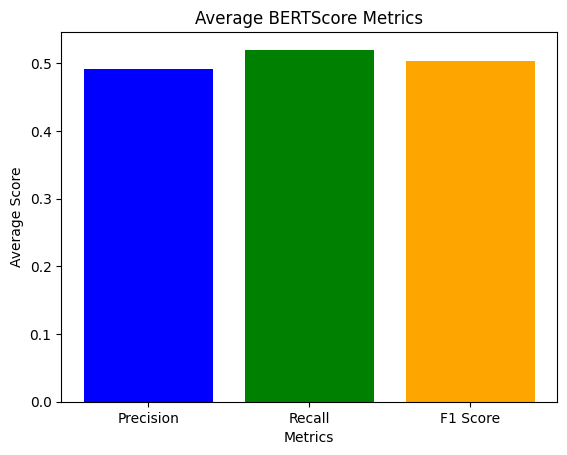

In [ ]:
import json
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from bert_score import score
import matplotlib.pyplot as plt

# Function to get model response
def get_model_response(question):
    prompt = f"<|start_header_id|>system<|end_header_id|> Answer the question truthfully, you are a medical professional.<|eot_id|><|start_header_id|>user<|end_header_id|> This is the question: {question} <|eot_id|>"
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=500, use_cache=True)
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

# Load JSON data from file
with open('ehealthforumQAs.json', 'r') as file:
    data = json.load(file)

precision_scores = []
recall_scores = []
f1_scores = []

# Process each question in the JSON data
for entry in data:
    question = entry["question"]
    expected_answer = entry["answer"]

    # Get the model response
    generated_answer = get_model_response(question)

    # Compute BERTScore
    P, R, F1 = score([generated_answer], [expected_answer], lang="en", model_type="bert-base-uncased")

    print(f"Question: {question}")
    print(f"Expected Answer: {expected_answer}")
    print(f"Generated Answer: {generated_answer}")
    print(f"BERTScore - Precision: {P.mean().item()}, Recall: {R.mean().item()}, F1: {F1.mean().item()}\n")

    # Append scores to respective lists
    precision_scores.append(P.mean().item())
    recall_scores.append(R.mean().item())
    f1_scores.append(F1.mean().item())

# Calculate average scores
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)

# Plotting graphs
scores = [avg_precision, avg_recall, avg_f1]
metrics = ["Precision", "Recall", "F1 Score"]

plt.bar(metrics, scores, color=['blue', 'green', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Average Score')
plt.title('Average BERTScore Metrics')
plt.show()


In [ ]:
print(avg_precision)

0.4921195660418237


In [ ]:
scores = [avg_precision, avg_recall, avg_f1]
metrics = ["Precision", "Recall", "F1 Score"]

plt.bar(metrics, scores, color=['blue', 'green', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Average Score')
plt.title('Average BERTScore Metrics')
plt.show()

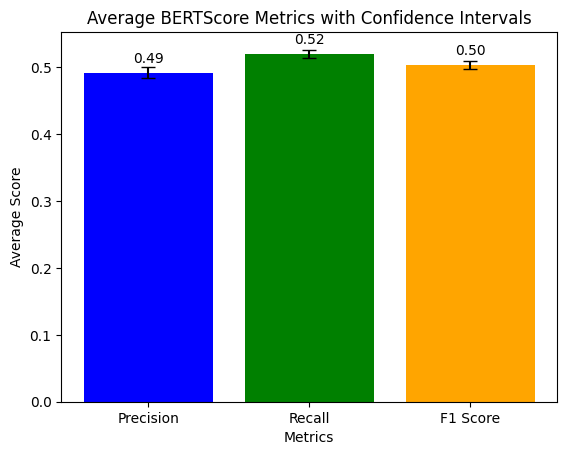

In [ ]:
import numpy as np
from scipy.stats import t

confidence_level = 0.95
degrees_freedom = len(precision_scores) - 1
t_value = t.ppf((1 + confidence_level) / 2, degrees_freedom)

precision_error = t_value * np.std(precision_scores) / np.sqrt(len(precision_scores))
recall_error = t_value * np.std(recall_scores) / np.sqrt(len(recall_scores))
f1_error = t_value * np.std(f1_scores) / np.sqrt(len(f1_scores))

# Plotting graphs
scores = [avg_precision, avg_recall, avg_f1]
errors = [precision_error, recall_error, f1_error]
metrics = ["Precision", "Recall", "F1 Score"]

plt.bar(metrics, scores, color=['blue', 'green', 'orange'], yerr=errors, capsize=5)
plt.xlabel('Metrics')
plt.ylabel('Average Score')
plt.title('Average BERTScore Metrics with Confidence Intervals')
for i in range(len(scores)):
    plt.text(i, scores[i] + 0.01, f"{scores[i]:.2f}", ha='center', va='bottom')

plt.show()
